# Advance Machine Learning - Assignment 4
#### Villa Giacomo 807462

## Importing Libraries

In [1]:
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.models import Model
from keras.datasets import cifar10

from matplotlib import pyplot as plt
from matplotlib.image import imread
import matplotlib as mpl
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from PIL import Image

import glob
import cv2
import random

from tqdm import tqdm_notebook as tqdm

from collections import Counter

Using TensorFlow backend.


## Functions

In [2]:
def get_model(image_size):
    
    pre_trained = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    
    pre_trained.summary()

    return pre_trained
    
def display(image):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap = mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()
    
    
def map_fields(init_dict, map_dict, res_dict=None):

    res_dict = res_dict or {}
    for k, v in init_dict.items():

        if isinstance(v, dict):
            v = map_fields(v, map_dict[k])
        elif k in map_dict.keys():
            k = str(map_dict[k])
        res_dict[k] = v
    return res_dict

    
def get_distribution(classes):
    
    classes, counts = np.unique(classes, return_counts=True)
    distribution = dict(zip(classes, counts))
    
    new_key = {0: 'Airplane', 1: 'Frog', 2: 'Horse', 3: 'Ship'}
    
    classes_distribution = map_fields(distribution, new_key)
    
    label = list(classes_distribution.keys())
    values = list(classes_distribution.values())
    
    
    fig1, ax1 = plt.subplots()
    
    ax1.pie( values, labels = label , autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()
    
def preprocessing_data(train_in, train_out, test_in, test_out):
    
    train_in = np.array(train_in) 
    train_out = np.array(train_out) 

    test_in = np.array(test_in) 
    test_out = np.array(test_out) 
    
    
    train_in = train_in.reshape(20000, 32, 32, 3) 
    test_in = test_in.reshape(4000, 32, 32, 3)
    
    train_in = train_in.astype("float32")
    test_in = test_in.astype("float32")
    
    train_in /= 255.
    test_in /= 255.
    
    return train_in, train_out, test_in, test_out
    
def translate_in_range(index):
    if index == 0:
        value = 0
    elif index == 6:
        value = 1
    elif index == 7:
        value = 2
    else:
        value = 3
        
    return value

def one_hot_to_value(elements):
    
    values = list()
    
    for element in elements:    
        values.append(np.where(element == np.amax(element))[0][0])
        
    return values


def get_features(truncate_model, in_data):
    flatten_list = list()
    for i in tqdm(range(0, in_data.shape[0])):
        flatten_list.append(truncate_model.predict(np.expand_dims(in_data[i], axis=0)).flatten())
    
    return np.array(flatten_list)

def plotConfusionMatrix(y_true, y_pred, classes, normalize, title, cmap = plt.cm.get_cmap("Blues")):
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show(ax)

def get_class(index):
    if index == 0:
        return "Airplane"
    elif index == 1:
        return "Frog"
    elif index == 2:
        return "Horse"
    else:
        return "Ship"

## Loading Data and Preprocessing

In [3]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [4]:
train = list()
train_label = list()
 
test = list()
test_label = list()

value = 0

for i in tqdm(range(0, X_train.shape[0])):
    if Y_train[i][0] == 0 or Y_train[i][0] == 6 or Y_train[i][0] == 7 or Y_train[i][0] == 8:
        train.append(X_train[i])
        train_label.append(translate_in_range(Y_train[i][0]))
        
for i in tqdm(range(0, X_test.shape[0])):
    if (Y_test[i][0] == 0 or Y_test[i][0] == 6 or Y_test[i][0] == 7 or Y_test[i][0] == 8):        
        test.append(X_test[i])
        test_label.append(translate_in_range(Y_test[i][0]))
    

--------------------
X TRAIN SHAPE:  (20000, 32, 32, 3)
Y TRAIN SHAPE:  (20000,)

X TEST SHAPE:  (4000, 32, 32, 3)
Y TEST SHAPE:  (4000,)
--------------------
TRAIN LABEL DISTRIBUTION


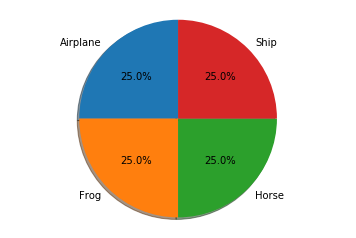

In [5]:
train_x, train_y, test_x, test_y = preprocessing_data(train, train_label, test, test_label)

print("--------------------")
print("X TRAIN SHAPE: ", train_x.shape)
print("Y TRAIN SHAPE: ", train_y.shape)
print("")
print("X TEST SHAPE: ", test_x.shape)
print("Y TEST SHAPE: ", test_y.shape)
print("--------------------")

print("TRAIN LABEL DISTRIBUTION")
get_distribution(train_y)

3


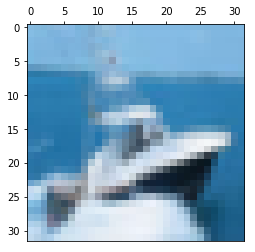

--------
0


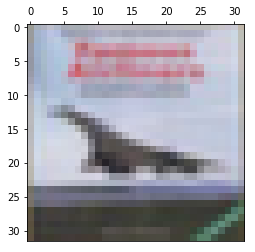

In [10]:
# {0: 'Airplane', 1: 'Frog', 2: 'Horse', 3: 'Ship'}
print(train_y[2])
display(train_x[2])
print("--------")
print(test_y[2])
display(test_x[2])

## Model Creation and Validation

In [7]:
model_accuracy = list()
pre_trained = get_model(32)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

# Cut to layer block1_pool

In [22]:
model = Model(inputs = pre_trained.input, outputs = pre_trained.get_layer('block1_pool').output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [23]:
flatten_train = get_features(model, train_x)
flatten_test = get_features(model, test_x)

In [24]:
print(flatten_train.shape)
print(flatten_test.shape)

(20000, 16384)
(4000, 16384)


In [25]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(flatten_train, train_y)

In [26]:
accuracy = svm_model_linear.score(flatten_test, test_y) 
model_accuracy.append(accuracy)

In [27]:
svm_predictions = svm_model_linear.predict(flatten_test) 

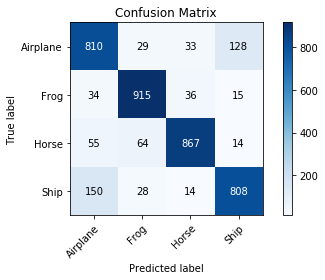

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.88      0.92      0.90      1000
           2       0.91      0.87      0.89      1000
           3       0.84      0.81      0.82      1000

   micro avg       0.85      0.85      0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000

0.85


In [28]:
plotConfusionMatrix(test_y, svm_predictions, ['Airplane', 'Frog', 'Horse', 'Ship'], False, "Confusion Matrix")
report = classification_report(test_y, svm_predictions)
print(report)
print(accuracy)

# Cut to layer block2_pool

In [37]:
model = Model(inputs = pre_trained.input, outputs = pre_trained.get_layer('block2_pool').output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [38]:
flatten_train = get_features(model, train_x)
flatten_test = get_features(model, test_x)

In [39]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(flatten_train, train_y)

In [40]:
accuracy = svm_model_linear.score(flatten_test, test_y) 
model_accuracy.append(accuracy)

In [41]:
svm_predictions = svm_model_linear.predict(flatten_test) 

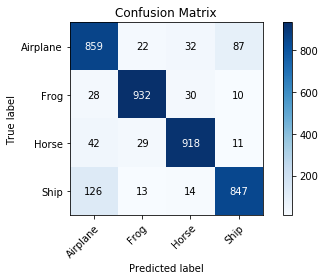

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1000
           1       0.94      0.93      0.93      1000
           2       0.92      0.92      0.92      1000
           3       0.89      0.85      0.87      1000

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000

0.889


In [43]:
plotConfusionMatrix(test_y, svm_predictions, ['Airplane', 'Frog', 'Horse', 'Ship'], False, "Confusion Matrix")
report = classification_report(test_y, svm_predictions)
print(report)
print(accuracy)

# Cut to layer block3_pool

In [8]:
model = Model(inputs = pre_trained.input, outputs = pre_trained.get_layer('block3_pool').output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [9]:
flatten_train = get_features(model, train_x)
flatten_test = get_features(model, test_x)

In [10]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(flatten_train, train_y)

In [11]:
accuracy = svm_model_linear.score(flatten_test, test_y) 
model_accuracy.append(accuracy)

In [12]:
svm_predictions = svm_model_linear.predict(flatten_test) 

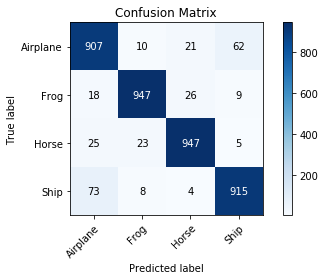

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1000
           1       0.96      0.95      0.95      1000
           2       0.95      0.95      0.95      1000
           3       0.92      0.92      0.92      1000

   micro avg       0.93      0.93      0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000

0.929


In [13]:
plotConfusionMatrix(test_y, svm_predictions, ['Airplane', 'Frog', 'Horse', 'Ship'], False, "Confusion Matrix")
report = classification_report(test_y, svm_predictions)
print(report)
print(accuracy)

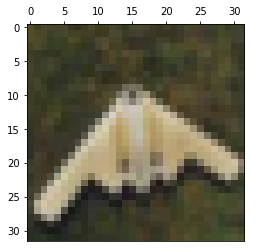

I PREDICT:  Horse
REAL VALUE:  Airplane



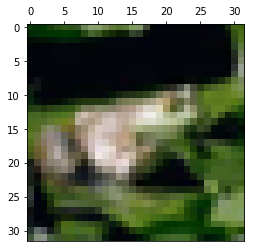

I PREDICT:  Ship
REAL VALUE:  Frog



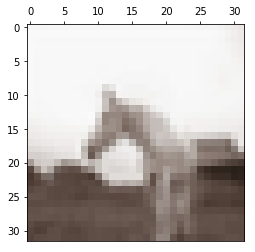

I PREDICT:  Airplane
REAL VALUE:  Horse



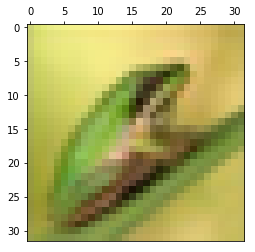

I PREDICT:  Airplane
REAL VALUE:  Frog



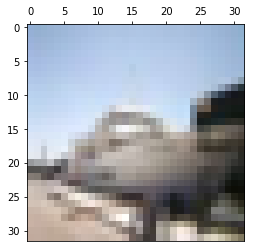

I PREDICT:  Airplane
REAL VALUE:  Ship



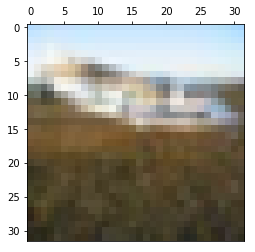

I PREDICT:  Ship
REAL VALUE:  Airplane



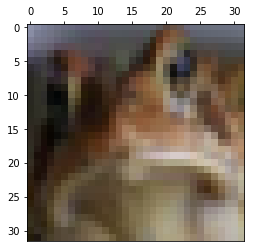

I PREDICT:  Horse
REAL VALUE:  Frog



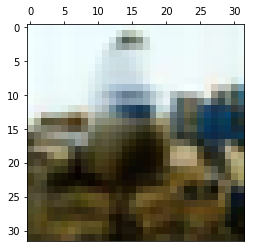

I PREDICT:  Horse
REAL VALUE:  Airplane



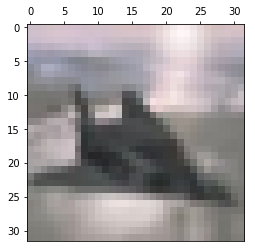

I PREDICT:  Ship
REAL VALUE:  Airplane



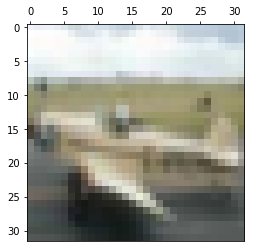

I PREDICT:  Ship
REAL VALUE:  Airplane



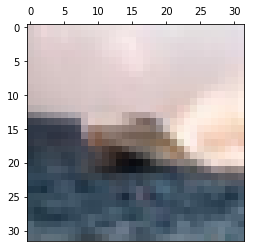

I PREDICT:  Airplane
REAL VALUE:  Ship



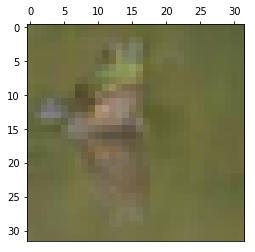

I PREDICT:  Horse
REAL VALUE:  Frog



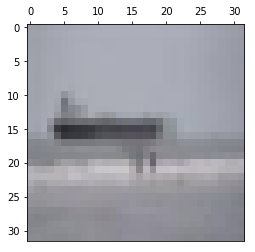

I PREDICT:  Airplane
REAL VALUE:  Ship



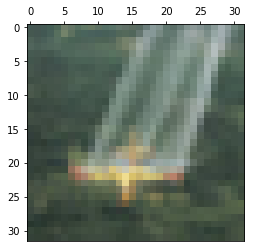

I PREDICT:  Ship
REAL VALUE:  Airplane



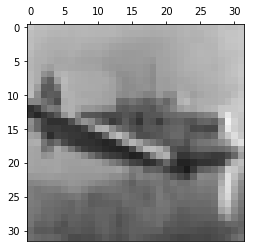

I PREDICT:  Ship
REAL VALUE:  Airplane



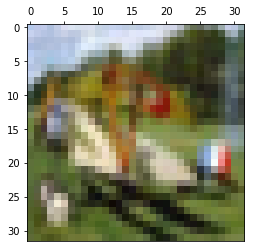

I PREDICT:  Frog
REAL VALUE:  Airplane



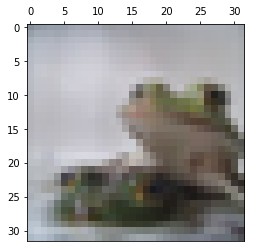

I PREDICT:  Airplane
REAL VALUE:  Frog



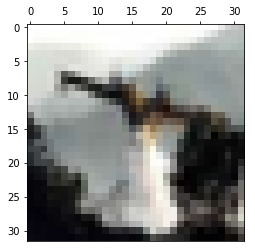

I PREDICT:  Ship
REAL VALUE:  Airplane



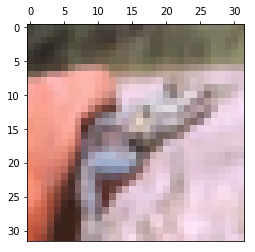

I PREDICT:  Horse
REAL VALUE:  Frog



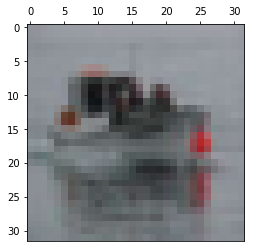

I PREDICT:  Frog
REAL VALUE:  Ship



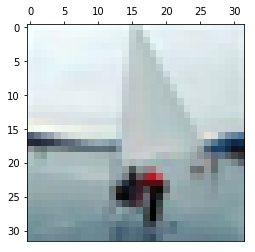

I PREDICT:  Airplane
REAL VALUE:  Ship



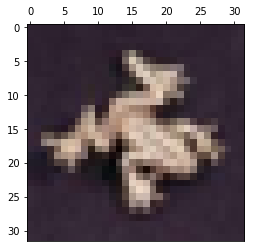

I PREDICT:  Airplane
REAL VALUE:  Frog



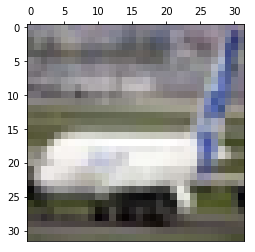

I PREDICT:  Ship
REAL VALUE:  Airplane



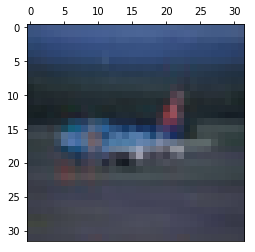

I PREDICT:  Ship
REAL VALUE:  Airplane



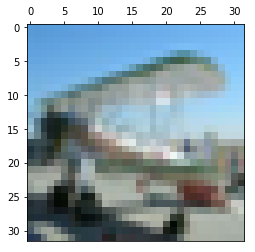

I PREDICT:  Ship
REAL VALUE:  Airplane



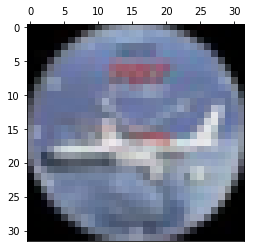

I PREDICT:  Ship
REAL VALUE:  Airplane



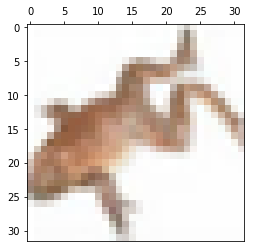

I PREDICT:  Horse
REAL VALUE:  Frog



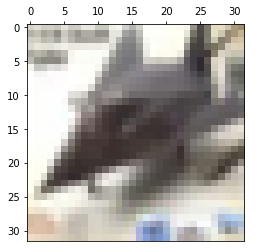

I PREDICT:  Horse
REAL VALUE:  Airplane



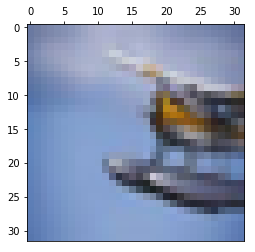

I PREDICT:  Ship
REAL VALUE:  Airplane



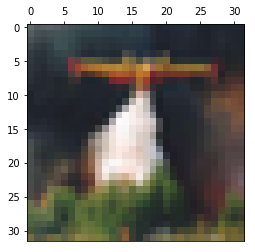

I PREDICT:  Horse
REAL VALUE:  Airplane



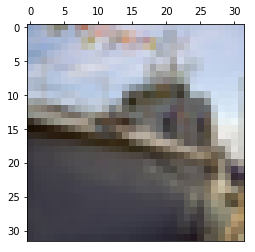

I PREDICT:  Airplane
REAL VALUE:  Ship



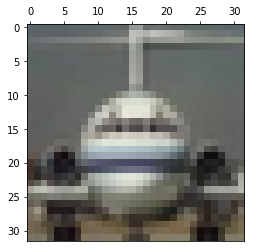

I PREDICT:  Ship
REAL VALUE:  Airplane



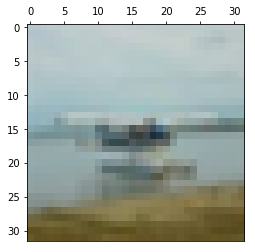

I PREDICT:  Ship
REAL VALUE:  Airplane



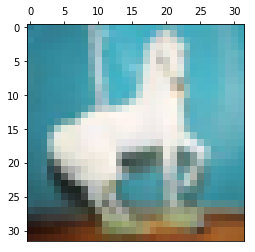

I PREDICT:  Ship
REAL VALUE:  Horse



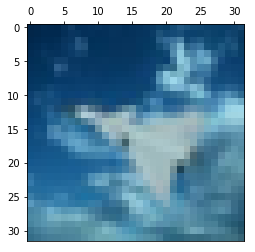

I PREDICT:  Ship
REAL VALUE:  Airplane



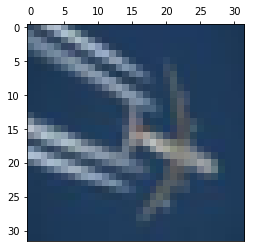

I PREDICT:  Ship
REAL VALUE:  Airplane



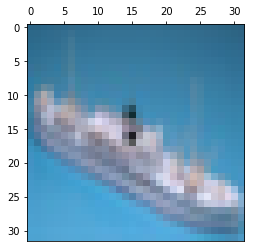

I PREDICT:  Airplane
REAL VALUE:  Ship



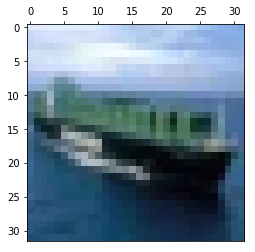

I PREDICT:  Airplane
REAL VALUE:  Ship



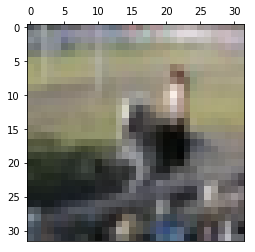

I PREDICT:  Frog
REAL VALUE:  Horse



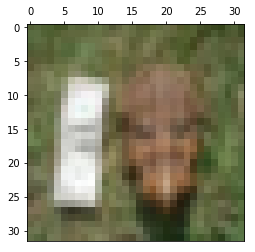

I PREDICT:  Horse
REAL VALUE:  Frog



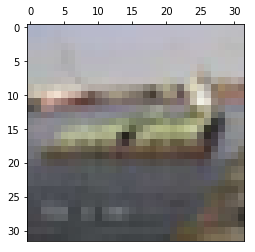

I PREDICT:  Airplane
REAL VALUE:  Ship



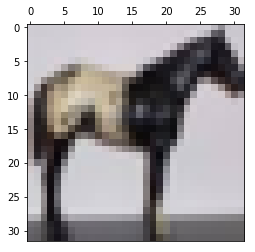

I PREDICT:  Airplane
REAL VALUE:  Horse



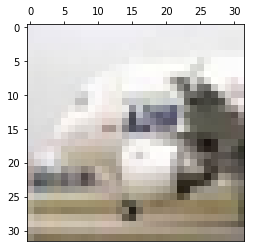

I PREDICT:  Horse
REAL VALUE:  Airplane



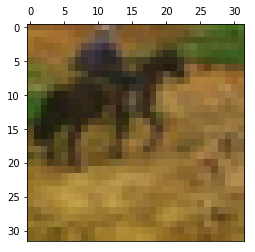

I PREDICT:  Frog
REAL VALUE:  Horse



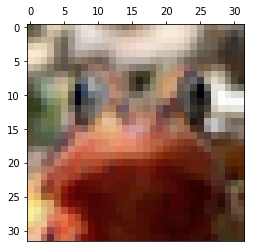

I PREDICT:  Horse
REAL VALUE:  Frog



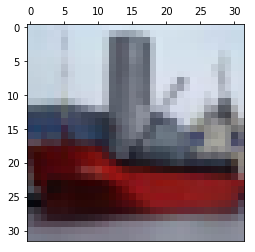

I PREDICT:  Airplane
REAL VALUE:  Ship



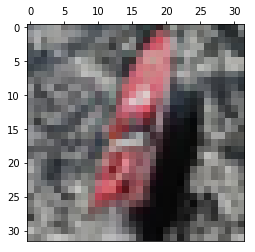

I PREDICT:  Frog
REAL VALUE:  Ship



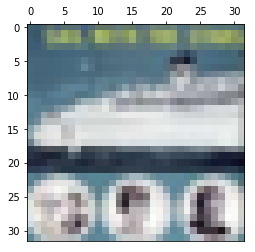

I PREDICT:  Airplane
REAL VALUE:  Ship



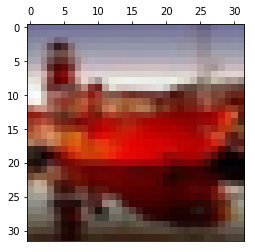

I PREDICT:  Airplane
REAL VALUE:  Ship



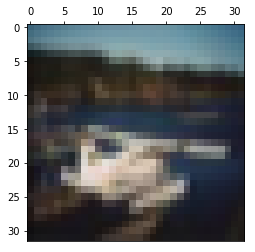

I PREDICT:  Ship
REAL VALUE:  Airplane



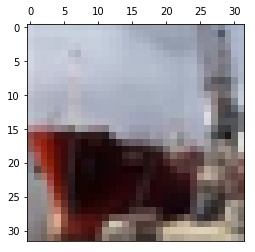

I PREDICT:  Airplane
REAL VALUE:  Ship



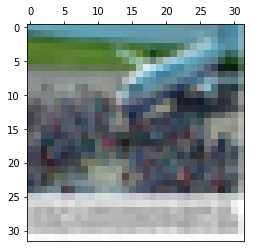

I PREDICT:  Horse
REAL VALUE:  Airplane



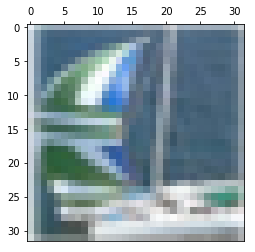

I PREDICT:  Airplane
REAL VALUE:  Ship



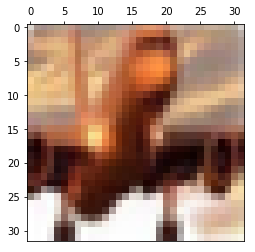

I PREDICT:  Horse
REAL VALUE:  Airplane



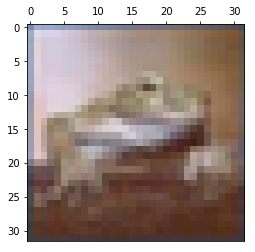

I PREDICT:  Airplane
REAL VALUE:  Frog



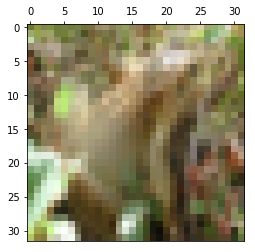

I PREDICT:  Horse
REAL VALUE:  Frog



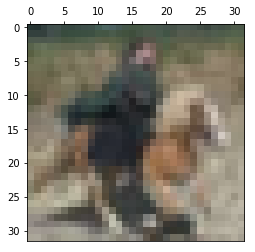

I PREDICT:  Frog
REAL VALUE:  Horse



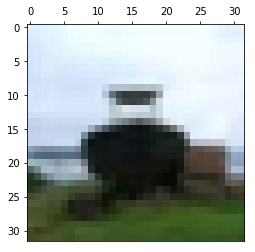

I PREDICT:  Airplane
REAL VALUE:  Ship



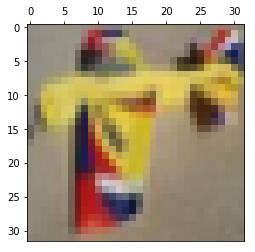

I PREDICT:  Horse
REAL VALUE:  Airplane



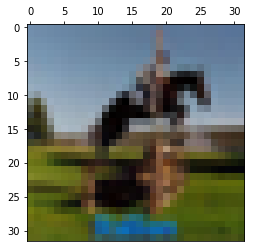

I PREDICT:  Airplane
REAL VALUE:  Horse



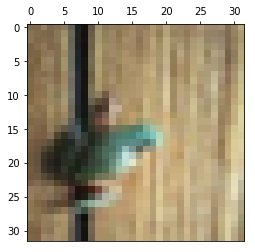

I PREDICT:  Horse
REAL VALUE:  Frog



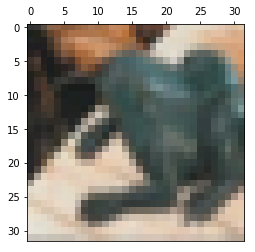

I PREDICT:  Horse
REAL VALUE:  Frog



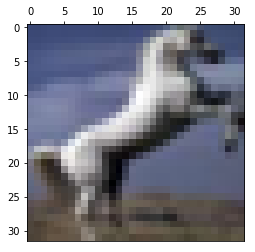

I PREDICT:  Airplane
REAL VALUE:  Horse



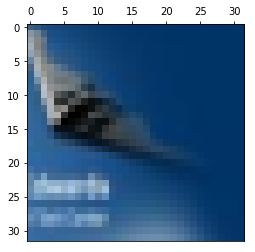

I PREDICT:  Ship
REAL VALUE:  Airplane



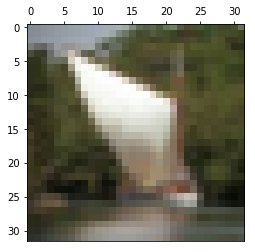

I PREDICT:  Airplane
REAL VALUE:  Ship



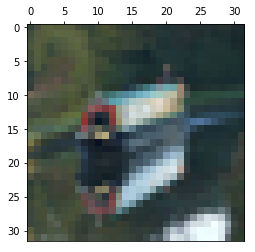

I PREDICT:  Frog
REAL VALUE:  Ship



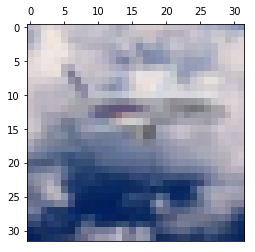

I PREDICT:  Ship
REAL VALUE:  Airplane



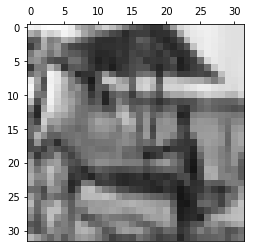

I PREDICT:  Ship
REAL VALUE:  Airplane



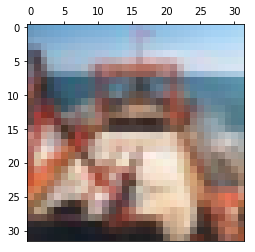

I PREDICT:  Horse
REAL VALUE:  Ship



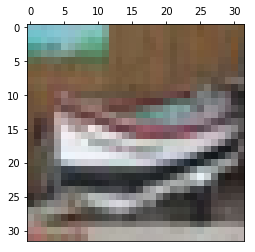

I PREDICT:  Airplane
REAL VALUE:  Ship



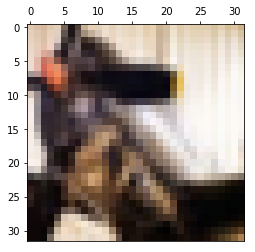

I PREDICT:  Horse
REAL VALUE:  Airplane



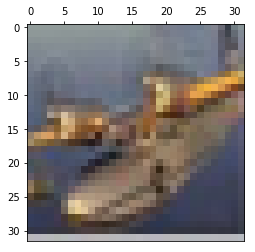

I PREDICT:  Ship
REAL VALUE:  Airplane



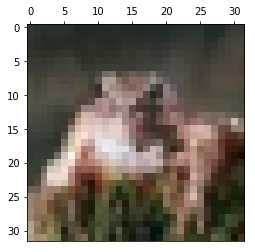

I PREDICT:  Horse
REAL VALUE:  Frog



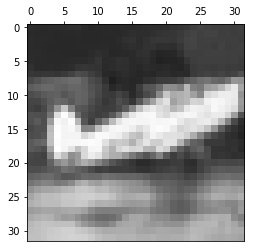

I PREDICT:  Ship
REAL VALUE:  Airplane



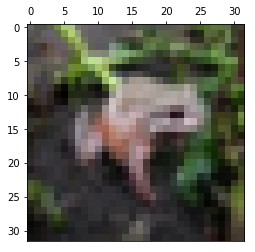

I PREDICT:  Horse
REAL VALUE:  Frog



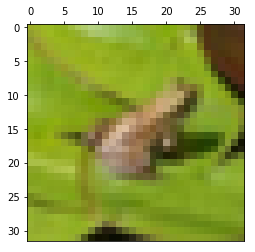

I PREDICT:  Airplane
REAL VALUE:  Frog



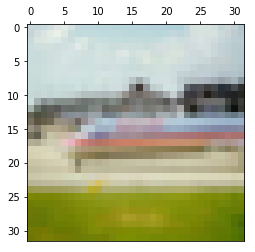

I PREDICT:  Ship
REAL VALUE:  Airplane



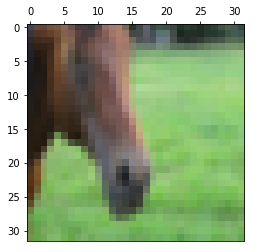

I PREDICT:  Frog
REAL VALUE:  Horse



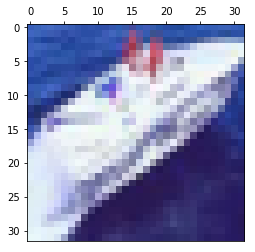

I PREDICT:  Airplane
REAL VALUE:  Ship



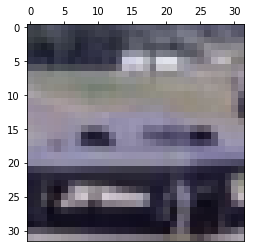

I PREDICT:  Ship
REAL VALUE:  Airplane



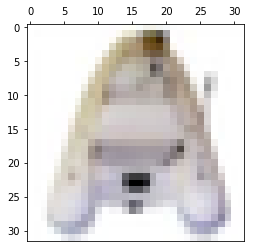

I PREDICT:  Frog
REAL VALUE:  Ship



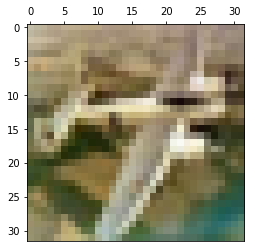

I PREDICT:  Frog
REAL VALUE:  Airplane



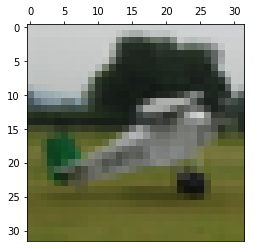

I PREDICT:  Horse
REAL VALUE:  Airplane



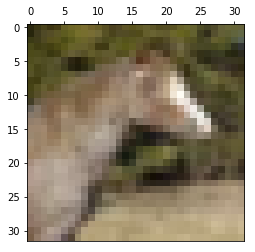

I PREDICT:  Frog
REAL VALUE:  Horse



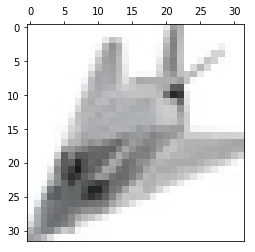

I PREDICT:  Ship
REAL VALUE:  Airplane



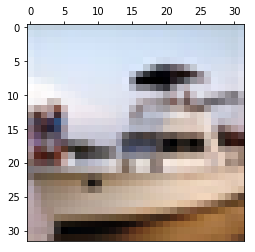

I PREDICT:  Airplane
REAL VALUE:  Ship



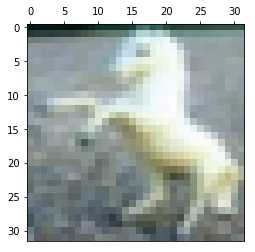

I PREDICT:  Frog
REAL VALUE:  Horse



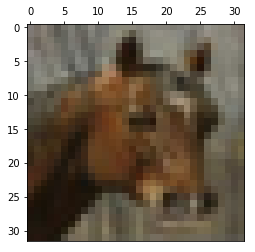

I PREDICT:  Frog
REAL VALUE:  Horse



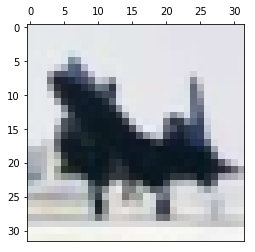

I PREDICT:  Horse
REAL VALUE:  Airplane



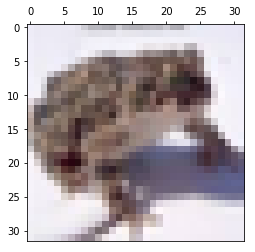

I PREDICT:  Airplane
REAL VALUE:  Frog



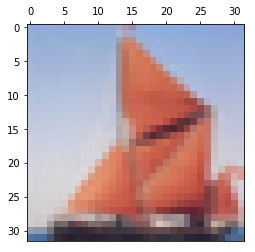

I PREDICT:  Airplane
REAL VALUE:  Ship



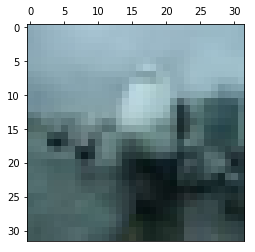

I PREDICT:  Ship
REAL VALUE:  Airplane



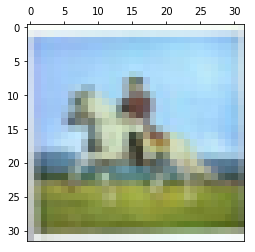

I PREDICT:  Ship
REAL VALUE:  Horse



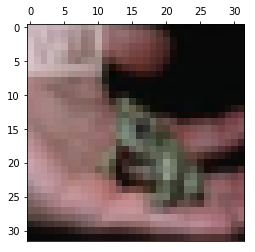

I PREDICT:  Airplane
REAL VALUE:  Frog



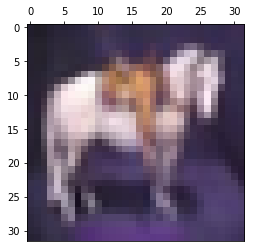

I PREDICT:  Frog
REAL VALUE:  Horse



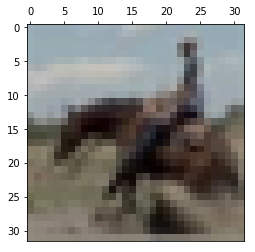

I PREDICT:  Airplane
REAL VALUE:  Horse



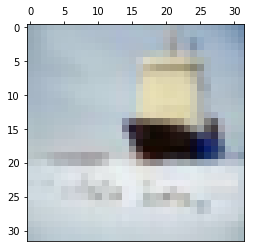

I PREDICT:  Airplane
REAL VALUE:  Ship



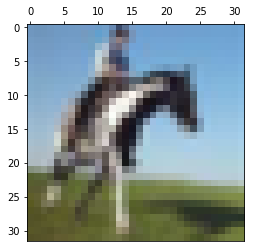

I PREDICT:  Airplane
REAL VALUE:  Horse



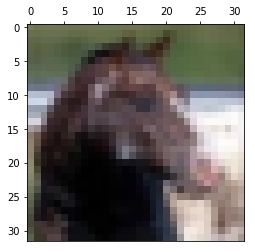

I PREDICT:  Frog
REAL VALUE:  Horse



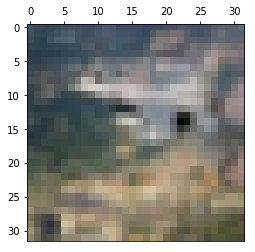

I PREDICT:  Frog
REAL VALUE:  Airplane



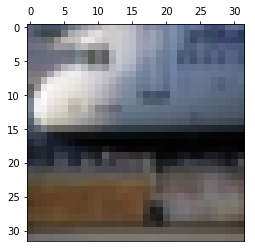

I PREDICT:  Ship
REAL VALUE:  Airplane



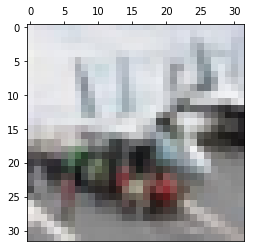

I PREDICT:  Ship
REAL VALUE:  Airplane



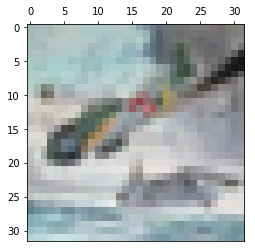

I PREDICT:  Ship
REAL VALUE:  Airplane



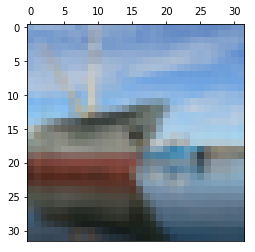

I PREDICT:  Airplane
REAL VALUE:  Ship



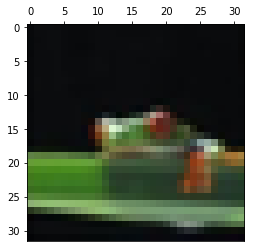

I PREDICT:  Horse
REAL VALUE:  Frog



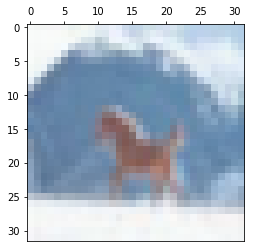

I PREDICT:  Airplane
REAL VALUE:  Horse



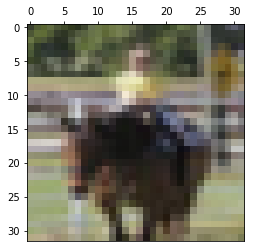

I PREDICT:  Frog
REAL VALUE:  Horse



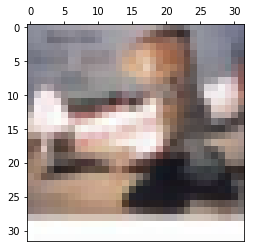

I PREDICT:  Horse
REAL VALUE:  Airplane



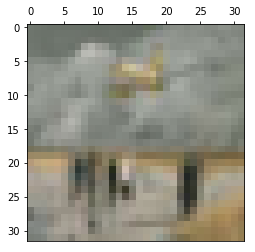

I PREDICT:  Horse
REAL VALUE:  Airplane



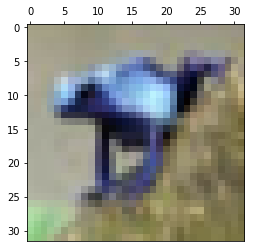

I PREDICT:  Horse
REAL VALUE:  Frog



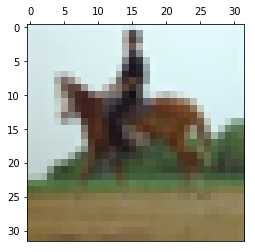

I PREDICT:  Airplane
REAL VALUE:  Horse



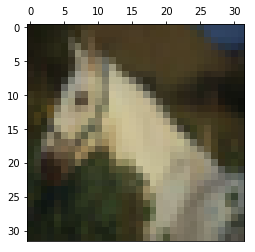

I PREDICT:  Frog
REAL VALUE:  Horse



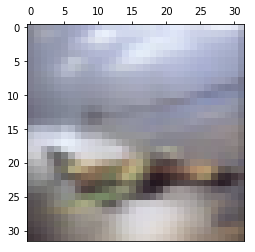

I PREDICT:  Ship
REAL VALUE:  Airplane



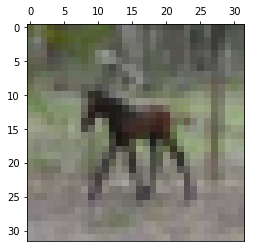

I PREDICT:  Frog
REAL VALUE:  Horse



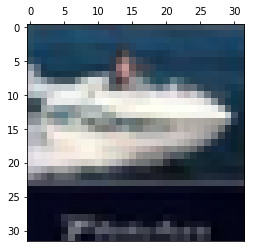

I PREDICT:  Airplane
REAL VALUE:  Ship



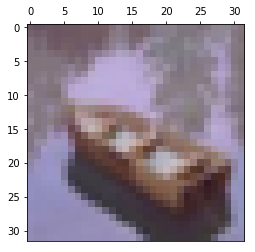

I PREDICT:  Frog
REAL VALUE:  Ship



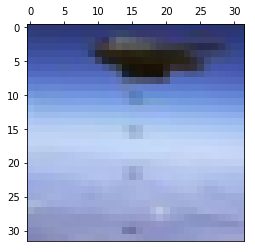

I PREDICT:  Ship
REAL VALUE:  Airplane



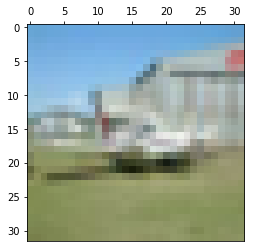

I PREDICT:  Ship
REAL VALUE:  Airplane



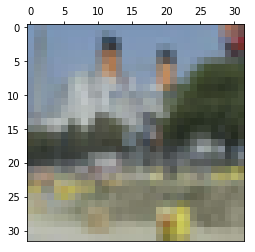

I PREDICT:  Horse
REAL VALUE:  Ship



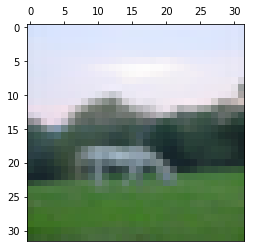

I PREDICT:  Airplane
REAL VALUE:  Horse



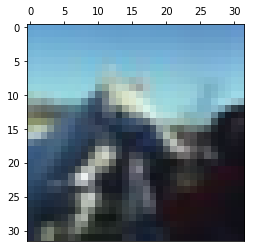

I PREDICT:  Airplane
REAL VALUE:  Horse



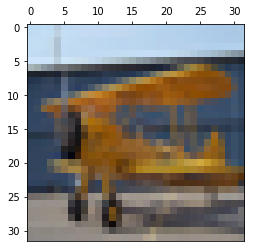

I PREDICT:  Ship
REAL VALUE:  Airplane



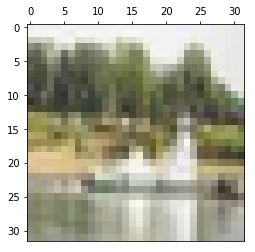

I PREDICT:  Airplane
REAL VALUE:  Ship



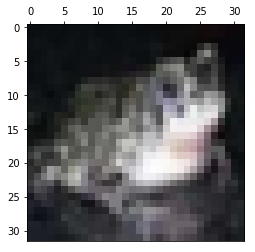

I PREDICT:  Ship
REAL VALUE:  Frog



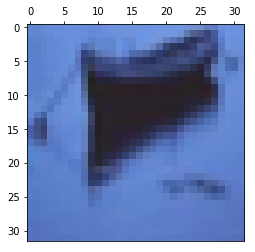

I PREDICT:  Airplane
REAL VALUE:  Ship



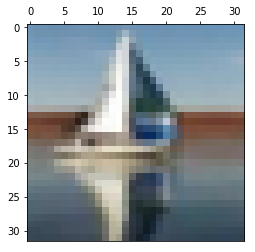

I PREDICT:  Airplane
REAL VALUE:  Ship



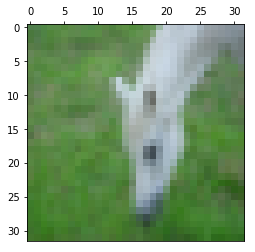

I PREDICT:  Airplane
REAL VALUE:  Horse



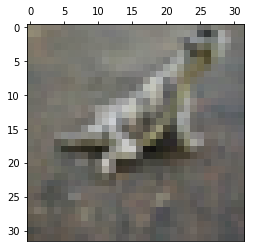

I PREDICT:  Airplane
REAL VALUE:  Frog



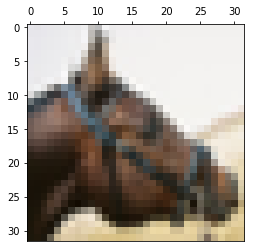

I PREDICT:  Airplane
REAL VALUE:  Horse



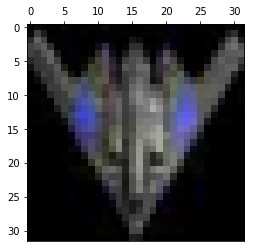

I PREDICT:  Ship
REAL VALUE:  Airplane



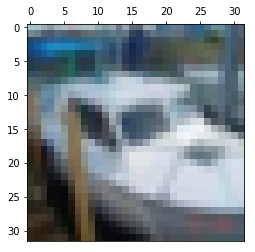

I PREDICT:  Airplane
REAL VALUE:  Ship



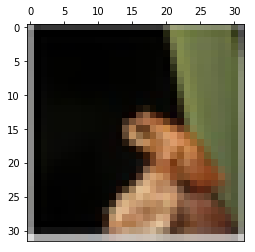

I PREDICT:  Horse
REAL VALUE:  Frog



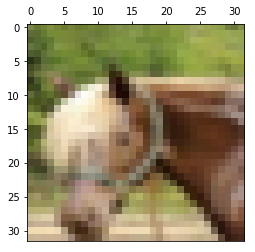

I PREDICT:  Frog
REAL VALUE:  Horse



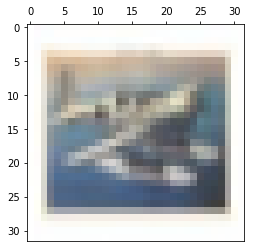

I PREDICT:  Frog
REAL VALUE:  Airplane



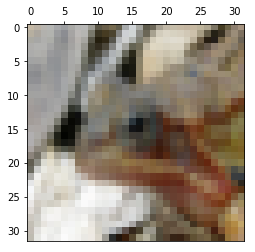

I PREDICT:  Airplane
REAL VALUE:  Frog



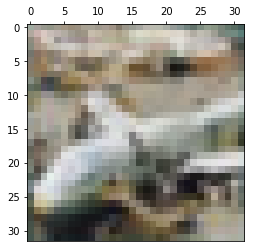

I PREDICT:  Frog
REAL VALUE:  Airplane



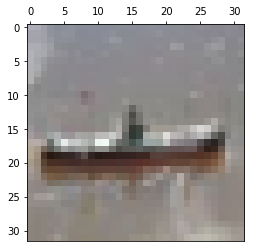

I PREDICT:  Airplane
REAL VALUE:  Ship



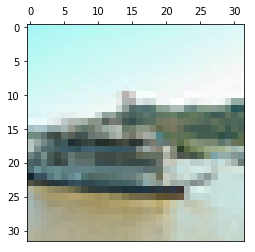

I PREDICT:  Airplane
REAL VALUE:  Ship



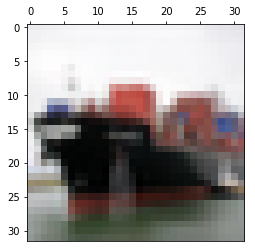

I PREDICT:  Airplane
REAL VALUE:  Ship



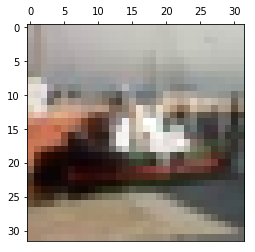

I PREDICT:  Airplane
REAL VALUE:  Ship



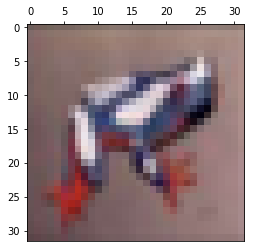

I PREDICT:  Airplane
REAL VALUE:  Frog



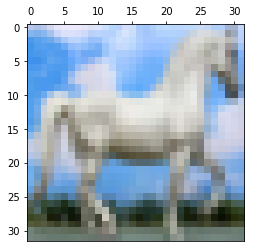

I PREDICT:  Airplane
REAL VALUE:  Horse



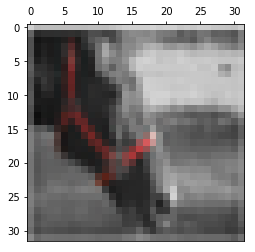

I PREDICT:  Ship
REAL VALUE:  Horse



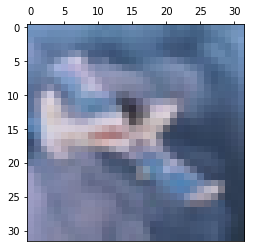

I PREDICT:  Ship
REAL VALUE:  Airplane



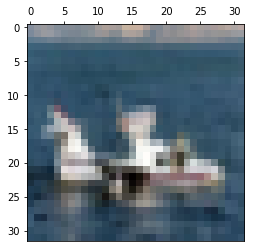

I PREDICT:  Ship
REAL VALUE:  Airplane



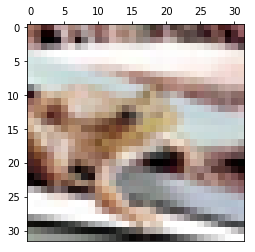

I PREDICT:  Horse
REAL VALUE:  Frog



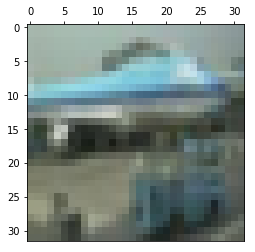

I PREDICT:  Ship
REAL VALUE:  Airplane



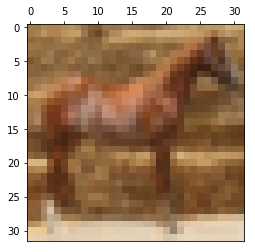

I PREDICT:  Frog
REAL VALUE:  Horse



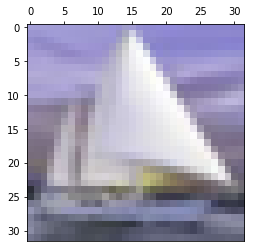

I PREDICT:  Airplane
REAL VALUE:  Ship



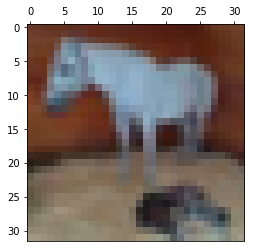

I PREDICT:  Airplane
REAL VALUE:  Horse



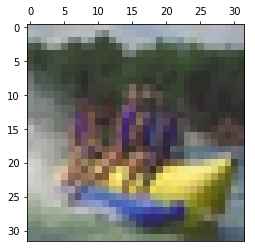

I PREDICT:  Frog
REAL VALUE:  Ship



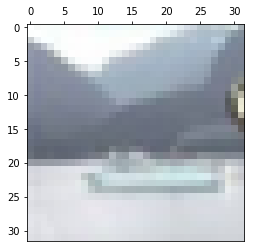

I PREDICT:  Airplane
REAL VALUE:  Ship



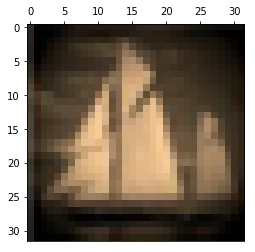

I PREDICT:  Horse
REAL VALUE:  Ship



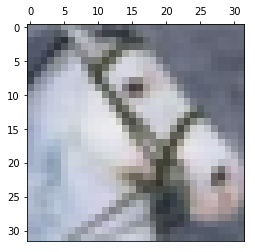

I PREDICT:  Airplane
REAL VALUE:  Horse



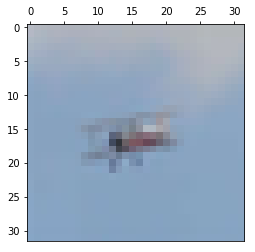

I PREDICT:  Ship
REAL VALUE:  Airplane



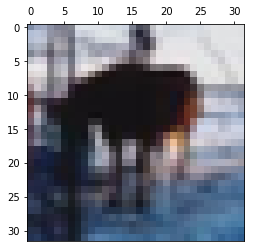

I PREDICT:  Airplane
REAL VALUE:  Horse



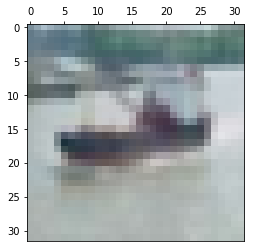

I PREDICT:  Airplane
REAL VALUE:  Ship



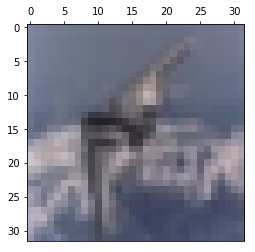

I PREDICT:  Ship
REAL VALUE:  Airplane



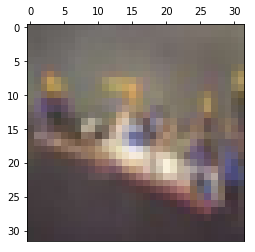

I PREDICT:  Airplane
REAL VALUE:  Ship



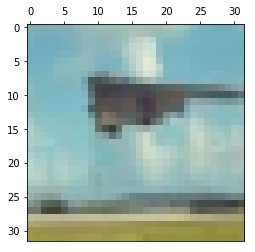

I PREDICT:  Ship
REAL VALUE:  Airplane



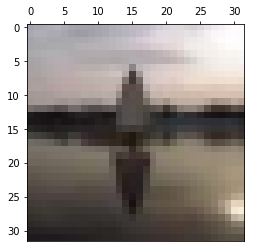

I PREDICT:  Airplane
REAL VALUE:  Ship



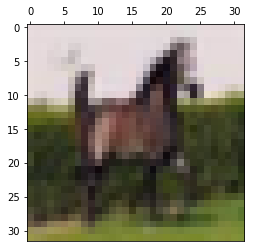

I PREDICT:  Airplane
REAL VALUE:  Horse



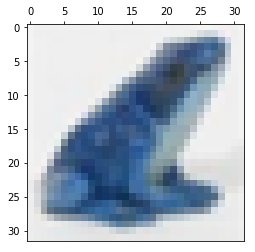

I PREDICT:  Ship
REAL VALUE:  Frog



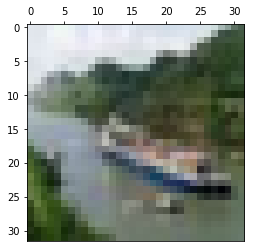

I PREDICT:  Airplane
REAL VALUE:  Ship



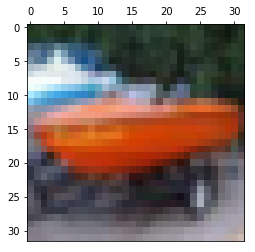

I PREDICT:  Airplane
REAL VALUE:  Ship



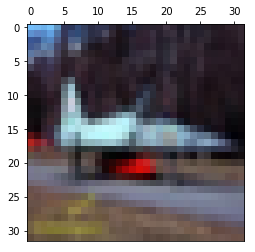

I PREDICT:  Ship
REAL VALUE:  Airplane



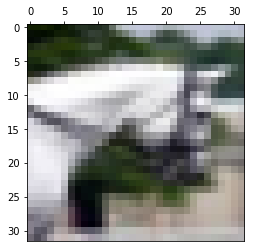

I PREDICT:  Airplane
REAL VALUE:  Horse



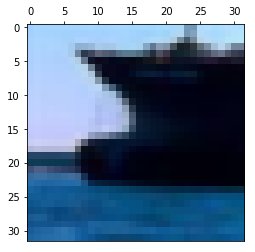

I PREDICT:  Airplane
REAL VALUE:  Ship



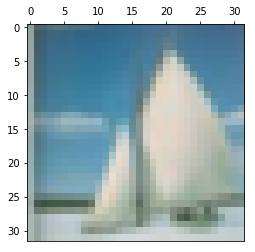

I PREDICT:  Airplane
REAL VALUE:  Ship



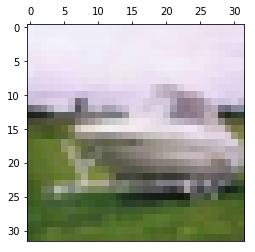

I PREDICT:  Airplane
REAL VALUE:  Ship



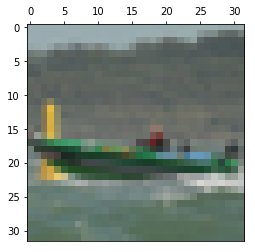

I PREDICT:  Airplane
REAL VALUE:  Ship



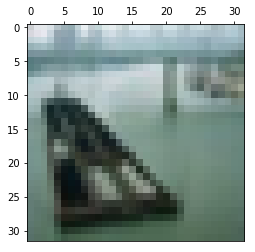

I PREDICT:  Airplane
REAL VALUE:  Ship



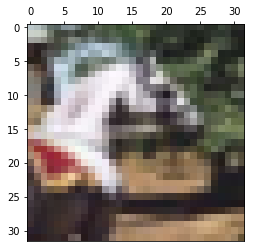

I PREDICT:  Ship
REAL VALUE:  Horse



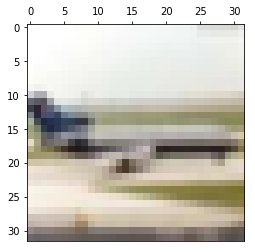

I PREDICT:  Ship
REAL VALUE:  Airplane



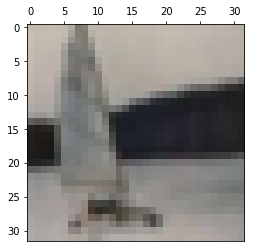

I PREDICT:  Airplane
REAL VALUE:  Ship



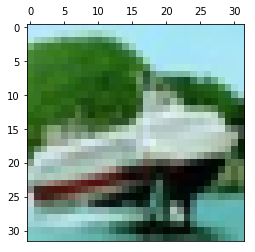

I PREDICT:  Airplane
REAL VALUE:  Ship



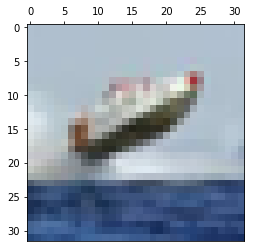

I PREDICT:  Airplane
REAL VALUE:  Ship



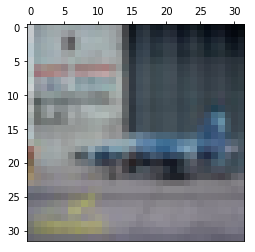

I PREDICT:  Ship
REAL VALUE:  Airplane



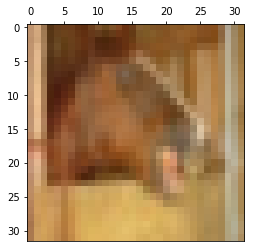

I PREDICT:  Frog
REAL VALUE:  Horse



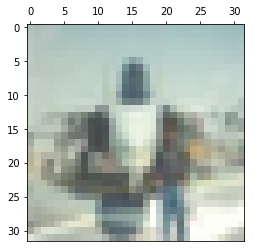

I PREDICT:  Horse
REAL VALUE:  Airplane



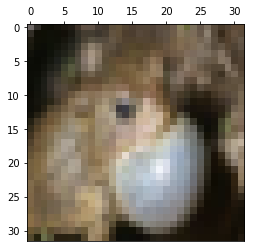

I PREDICT:  Horse
REAL VALUE:  Frog



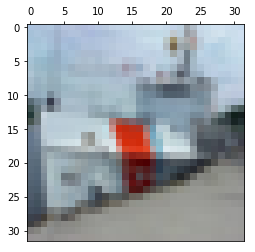

I PREDICT:  Airplane
REAL VALUE:  Ship



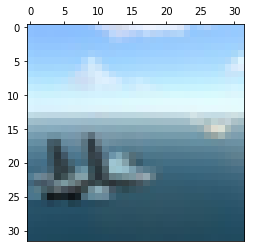

I PREDICT:  Ship
REAL VALUE:  Airplane



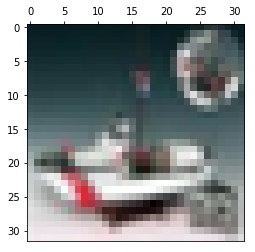

I PREDICT:  Frog
REAL VALUE:  Ship



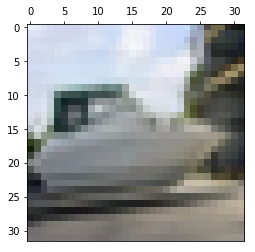

I PREDICT:  Airplane
REAL VALUE:  Ship



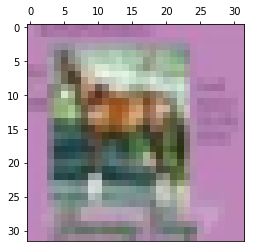

I PREDICT:  Frog
REAL VALUE:  Horse



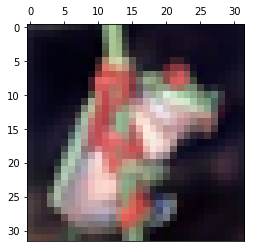

I PREDICT:  Horse
REAL VALUE:  Frog



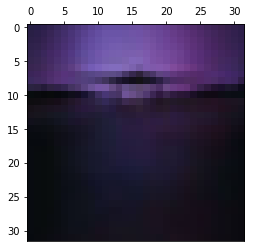

I PREDICT:  Ship
REAL VALUE:  Airplane



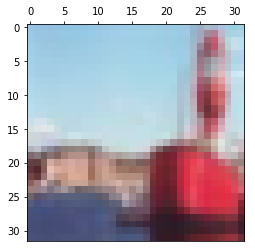

I PREDICT:  Airplane
REAL VALUE:  Ship



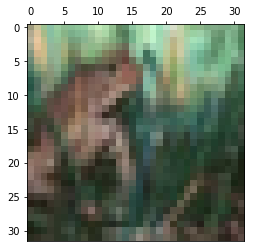

I PREDICT:  Horse
REAL VALUE:  Frog



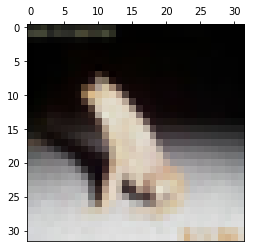

I PREDICT:  Horse
REAL VALUE:  Frog



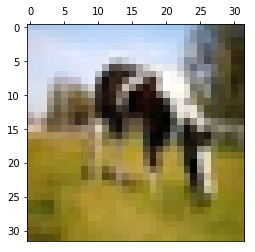

I PREDICT:  Airplane
REAL VALUE:  Horse



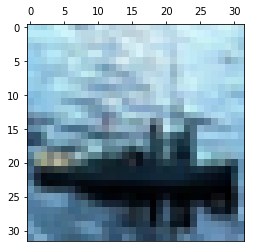

I PREDICT:  Airplane
REAL VALUE:  Ship



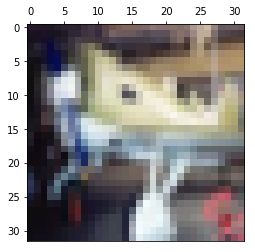

I PREDICT:  Horse
REAL VALUE:  Airplane



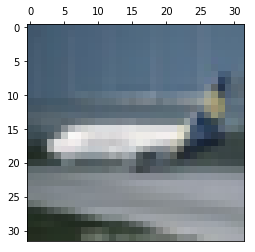

I PREDICT:  Ship
REAL VALUE:  Airplane



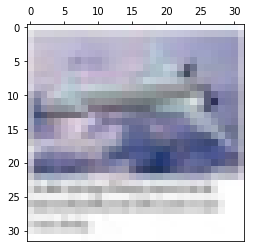

I PREDICT:  Ship
REAL VALUE:  Airplane



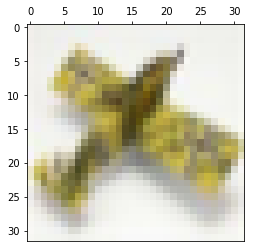

I PREDICT:  Frog
REAL VALUE:  Airplane



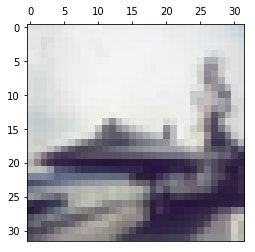

I PREDICT:  Ship
REAL VALUE:  Airplane



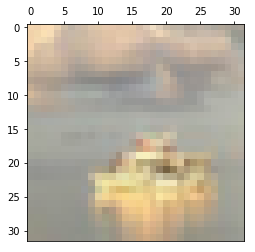

I PREDICT:  Frog
REAL VALUE:  Ship



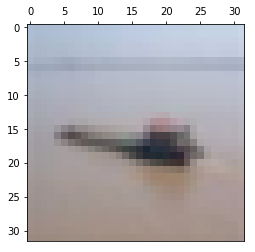

I PREDICT:  Airplane
REAL VALUE:  Ship



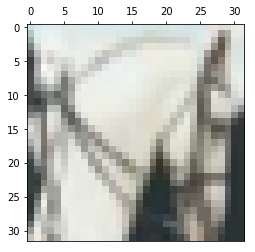

I PREDICT:  Ship
REAL VALUE:  Horse



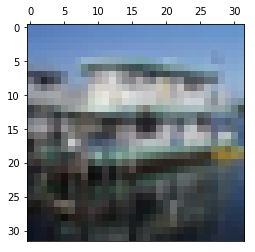

I PREDICT:  Airplane
REAL VALUE:  Ship



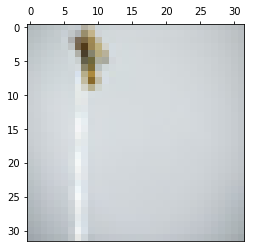

I PREDICT:  Ship
REAL VALUE:  Airplane



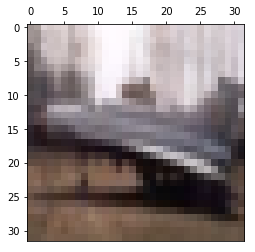

I PREDICT:  Ship
REAL VALUE:  Airplane



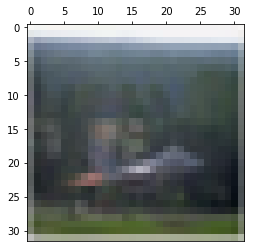

I PREDICT:  Ship
REAL VALUE:  Airplane



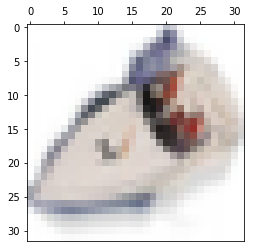

I PREDICT:  Airplane
REAL VALUE:  Ship



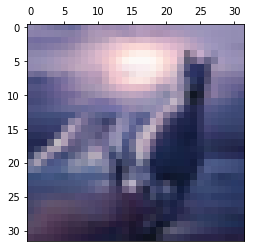

I PREDICT:  Airplane
REAL VALUE:  Horse



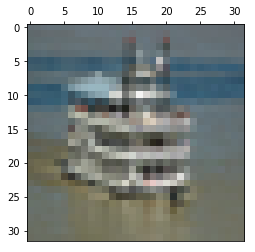

I PREDICT:  Airplane
REAL VALUE:  Ship



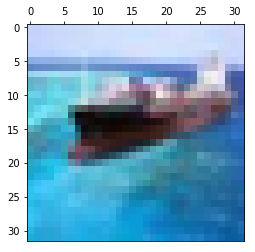

I PREDICT:  Airplane
REAL VALUE:  Ship



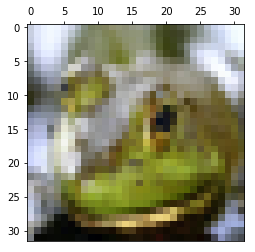

I PREDICT:  Ship
REAL VALUE:  Frog



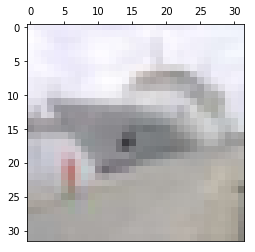

I PREDICT:  Airplane
REAL VALUE:  Ship



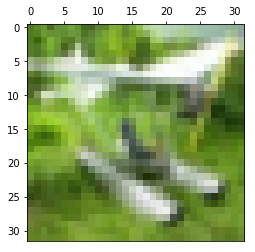

I PREDICT:  Frog
REAL VALUE:  Airplane



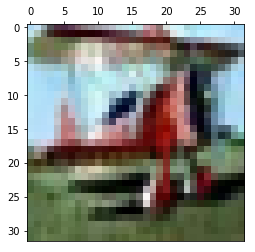

I PREDICT:  Horse
REAL VALUE:  Airplane



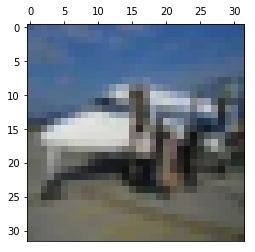

I PREDICT:  Horse
REAL VALUE:  Airplane



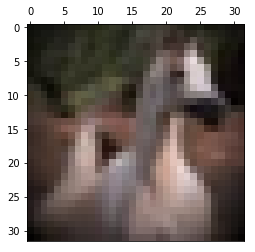

I PREDICT:  Frog
REAL VALUE:  Horse



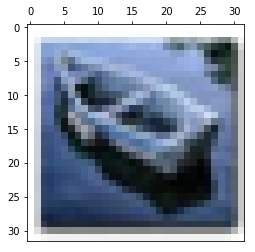

I PREDICT:  Airplane
REAL VALUE:  Ship



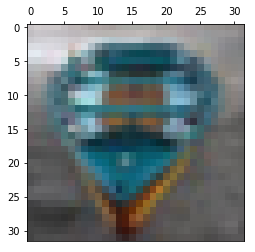

I PREDICT:  Airplane
REAL VALUE:  Ship



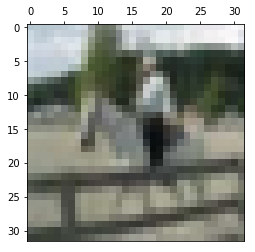

I PREDICT:  Airplane
REAL VALUE:  Horse



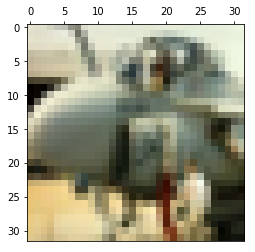

I PREDICT:  Horse
REAL VALUE:  Airplane



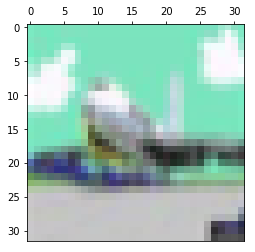

I PREDICT:  Ship
REAL VALUE:  Airplane



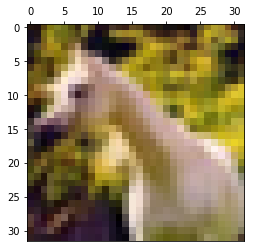

I PREDICT:  Frog
REAL VALUE:  Horse



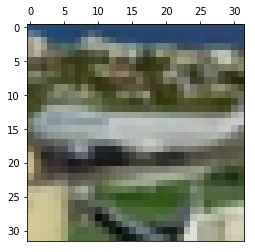

I PREDICT:  Ship
REAL VALUE:  Airplane



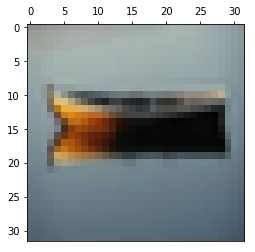

I PREDICT:  Airplane
REAL VALUE:  Ship



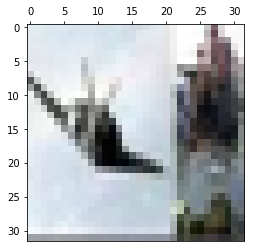

I PREDICT:  Ship
REAL VALUE:  Airplane



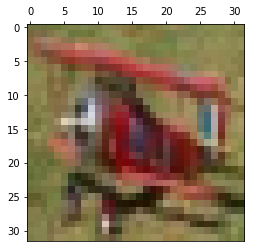

I PREDICT:  Frog
REAL VALUE:  Airplane



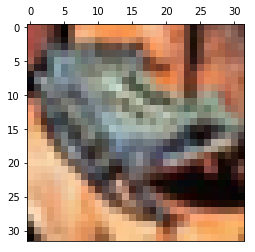

I PREDICT:  Airplane
REAL VALUE:  Frog



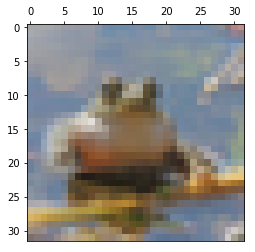

I PREDICT:  Ship
REAL VALUE:  Frog



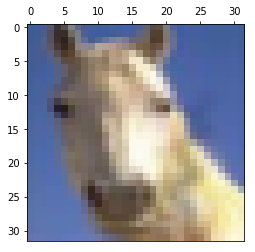

I PREDICT:  Frog
REAL VALUE:  Horse



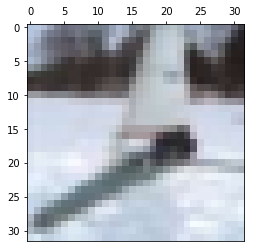

I PREDICT:  Airplane
REAL VALUE:  Ship



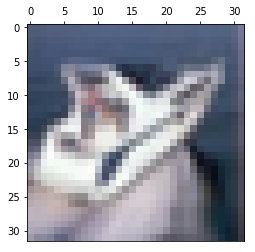

I PREDICT:  Airplane
REAL VALUE:  Ship



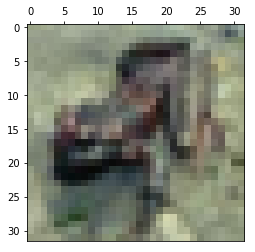

I PREDICT:  Horse
REAL VALUE:  Frog



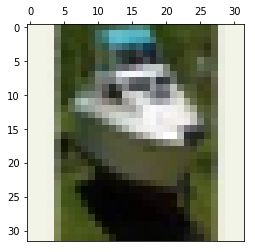

I PREDICT:  Airplane
REAL VALUE:  Ship



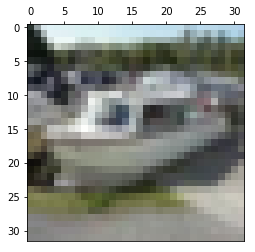

I PREDICT:  Airplane
REAL VALUE:  Ship



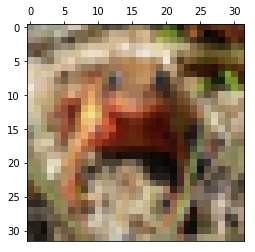

I PREDICT:  Horse
REAL VALUE:  Frog



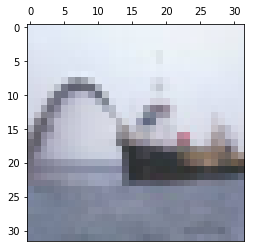

I PREDICT:  Airplane
REAL VALUE:  Ship



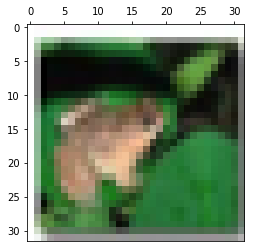

I PREDICT:  Airplane
REAL VALUE:  Frog



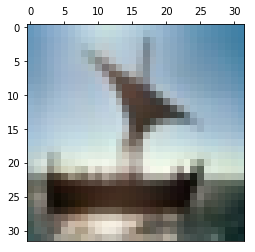

I PREDICT:  Airplane
REAL VALUE:  Ship



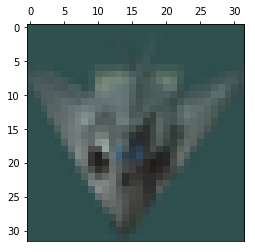

I PREDICT:  Frog
REAL VALUE:  Airplane



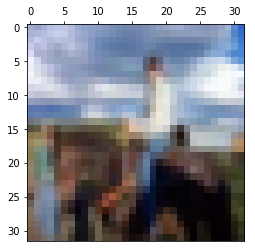

I PREDICT:  Airplane
REAL VALUE:  Horse



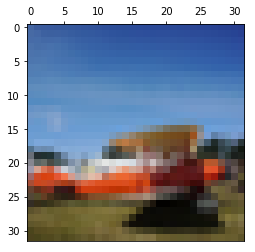

I PREDICT:  Ship
REAL VALUE:  Airplane



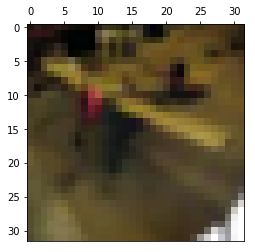

I PREDICT:  Frog
REAL VALUE:  Airplane



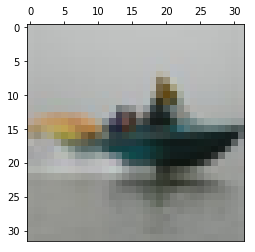

I PREDICT:  Airplane
REAL VALUE:  Ship



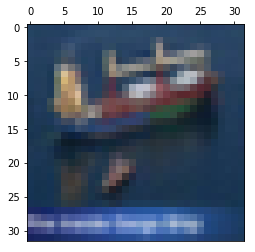

I PREDICT:  Airplane
REAL VALUE:  Ship



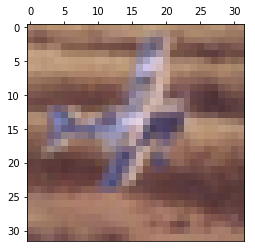

I PREDICT:  Horse
REAL VALUE:  Airplane



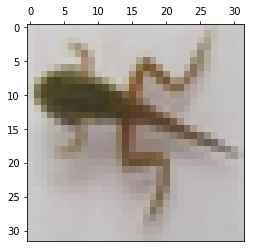

I PREDICT:  Airplane
REAL VALUE:  Frog



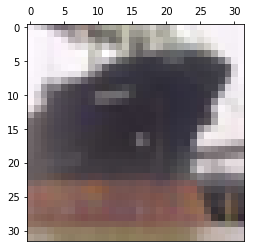

I PREDICT:  Horse
REAL VALUE:  Ship



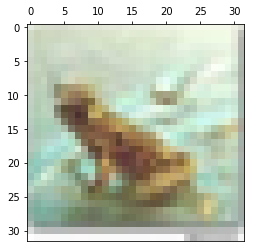

I PREDICT:  Ship
REAL VALUE:  Frog



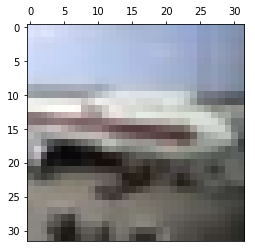

I PREDICT:  Ship
REAL VALUE:  Airplane



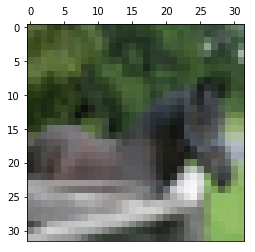

I PREDICT:  Frog
REAL VALUE:  Horse



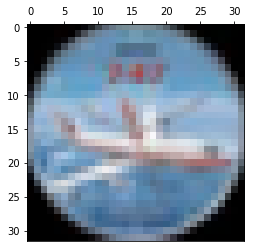

I PREDICT:  Ship
REAL VALUE:  Airplane



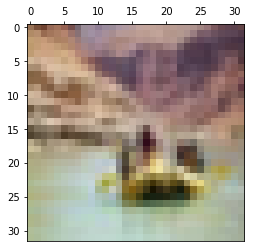

I PREDICT:  Airplane
REAL VALUE:  Ship



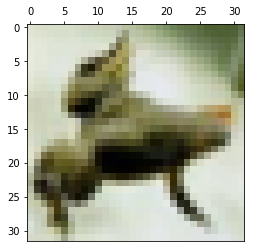

I PREDICT:  Airplane
REAL VALUE:  Frog



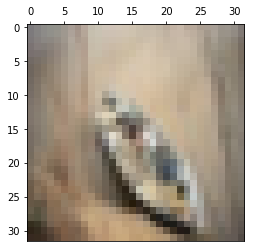

I PREDICT:  Airplane
REAL VALUE:  Ship



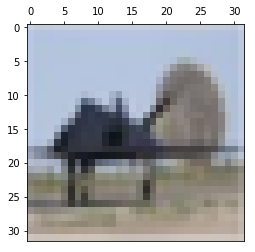

I PREDICT:  Horse
REAL VALUE:  Airplane



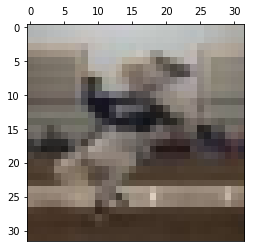

I PREDICT:  Airplane
REAL VALUE:  Horse



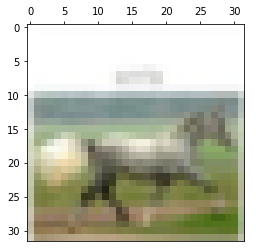

I PREDICT:  Airplane
REAL VALUE:  Horse



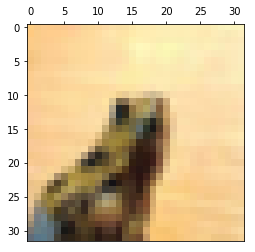

I PREDICT:  Horse
REAL VALUE:  Frog



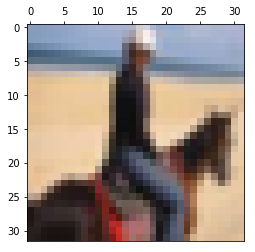

I PREDICT:  Airplane
REAL VALUE:  Horse



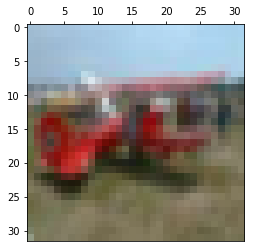

I PREDICT:  Ship
REAL VALUE:  Airplane



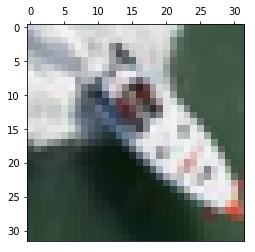

I PREDICT:  Airplane
REAL VALUE:  Ship



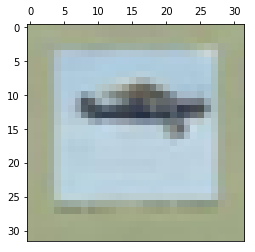

I PREDICT:  Ship
REAL VALUE:  Airplane



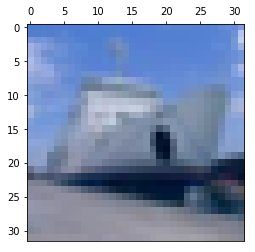

I PREDICT:  Airplane
REAL VALUE:  Ship



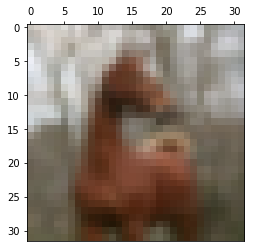

I PREDICT:  Frog
REAL VALUE:  Horse



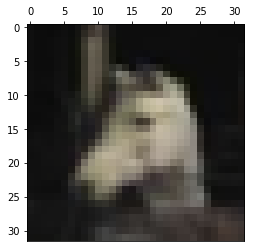

I PREDICT:  Frog
REAL VALUE:  Horse



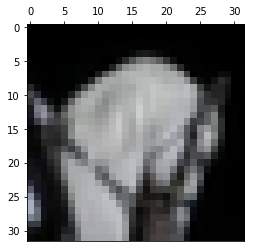

I PREDICT:  Frog
REAL VALUE:  Horse



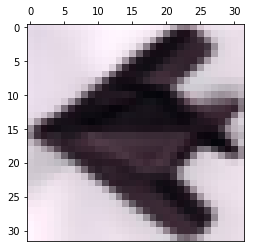

I PREDICT:  Ship
REAL VALUE:  Airplane



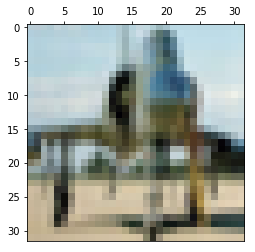

I PREDICT:  Horse
REAL VALUE:  Airplane



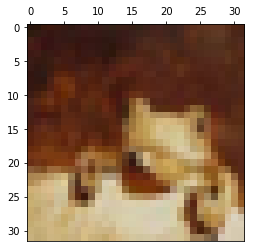

I PREDICT:  Horse
REAL VALUE:  Frog



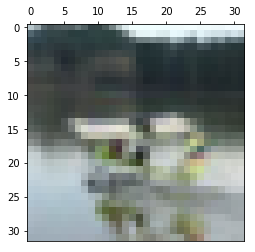

I PREDICT:  Ship
REAL VALUE:  Airplane



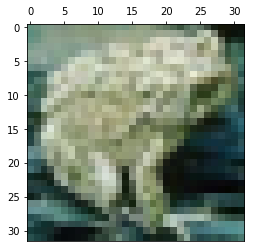

I PREDICT:  Ship
REAL VALUE:  Frog



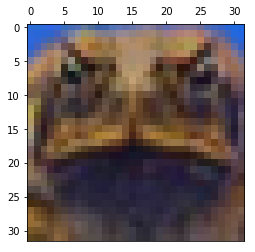

I PREDICT:  Airplane
REAL VALUE:  Frog



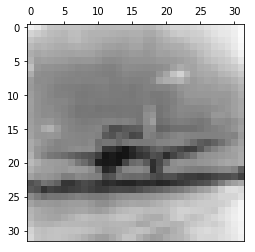

I PREDICT:  Ship
REAL VALUE:  Airplane



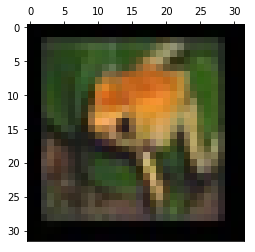

I PREDICT:  Horse
REAL VALUE:  Frog



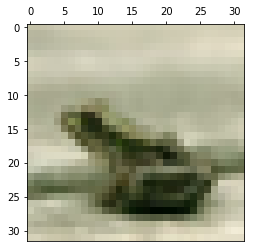

I PREDICT:  Ship
REAL VALUE:  Frog



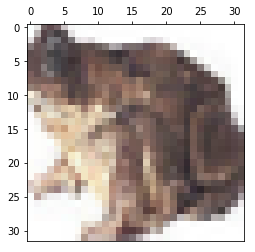

I PREDICT:  Horse
REAL VALUE:  Frog



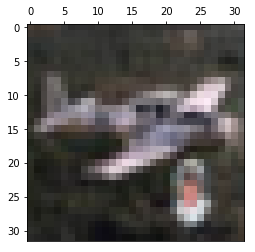

I PREDICT:  Ship
REAL VALUE:  Airplane



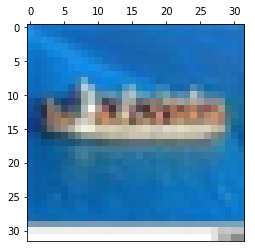

I PREDICT:  Airplane
REAL VALUE:  Ship



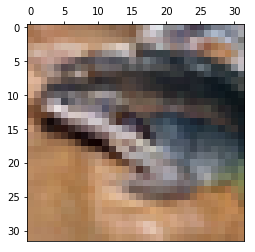

I PREDICT:  Ship
REAL VALUE:  Frog



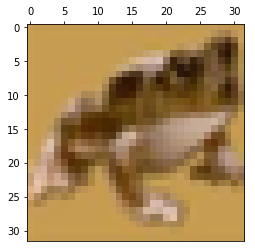

I PREDICT:  Airplane
REAL VALUE:  Frog



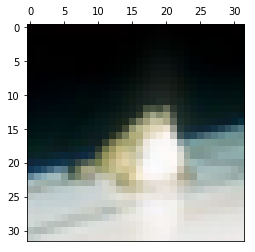

I PREDICT:  Horse
REAL VALUE:  Frog



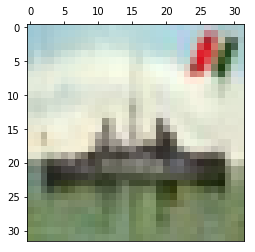

I PREDICT:  Airplane
REAL VALUE:  Ship



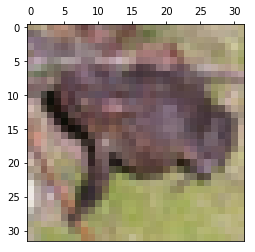

I PREDICT:  Airplane
REAL VALUE:  Frog



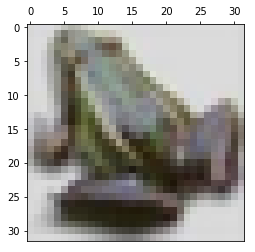

I PREDICT:  Airplane
REAL VALUE:  Frog



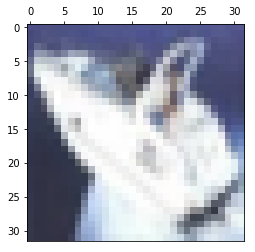

I PREDICT:  Airplane
REAL VALUE:  Ship

Total error:  284


In [19]:
cont = 0
for i in range(0, len(test_y)):
    if test_y[i] != svm_predictions[i]:
        display(test_x[i])
        print("I PREDICT: ", get_class(svm_predictions[i]))
        print("REAL VALUE: ", get_class(test_y[i]))
        cont += 1
        print("")
print("Total error: ",cont)

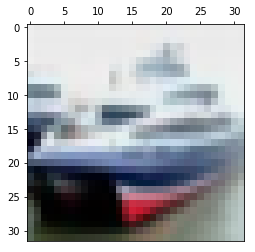

I PREDICT:  Ship
REAL VALUE:  Ship



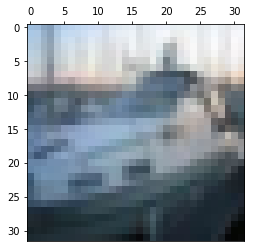

I PREDICT:  Ship
REAL VALUE:  Ship



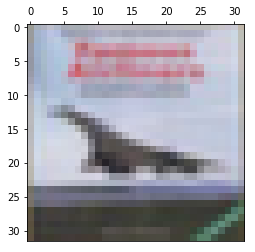

I PREDICT:  Airplane
REAL VALUE:  Airplane



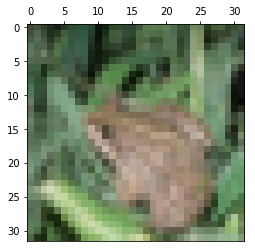

I PREDICT:  Frog
REAL VALUE:  Frog



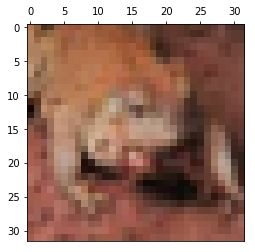

I PREDICT:  Frog
REAL VALUE:  Frog



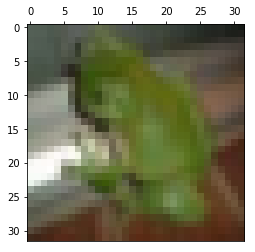

I PREDICT:  Frog
REAL VALUE:  Frog



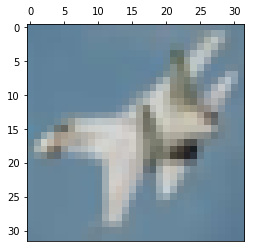

I PREDICT:  Airplane
REAL VALUE:  Airplane



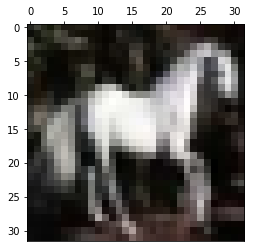

I PREDICT:  Horse
REAL VALUE:  Horse



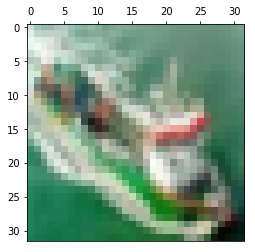

I PREDICT:  Ship
REAL VALUE:  Ship



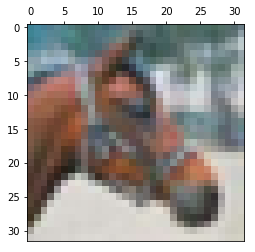

I PREDICT:  Horse
REAL VALUE:  Horse



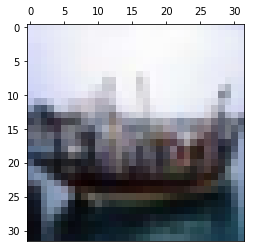

I PREDICT:  Ship
REAL VALUE:  Ship



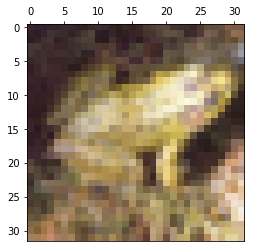

I PREDICT:  Frog
REAL VALUE:  Frog



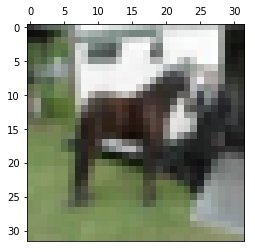

I PREDICT:  Horse
REAL VALUE:  Horse



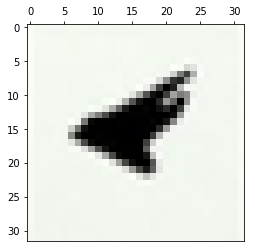

I PREDICT:  Airplane
REAL VALUE:  Airplane



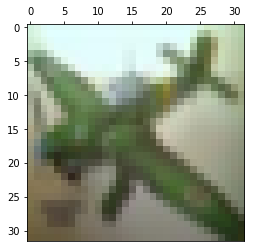

I PREDICT:  Airplane
REAL VALUE:  Airplane



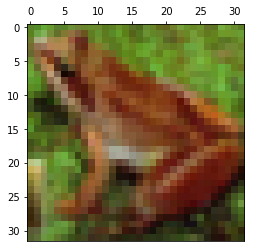

I PREDICT:  Frog
REAL VALUE:  Frog



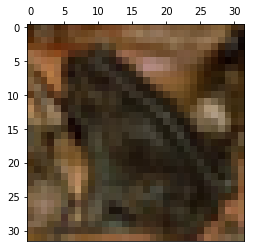

I PREDICT:  Frog
REAL VALUE:  Frog



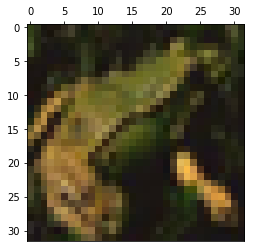

I PREDICT:  Frog
REAL VALUE:  Frog



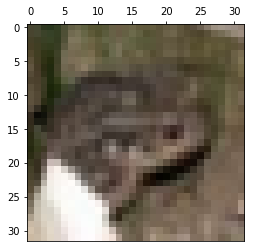

I PREDICT:  Frog
REAL VALUE:  Frog



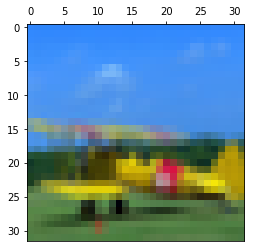

I PREDICT:  Airplane
REAL VALUE:  Airplane



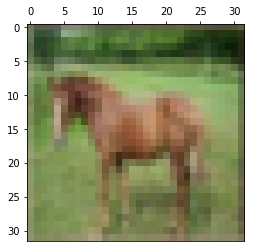

I PREDICT:  Horse
REAL VALUE:  Horse



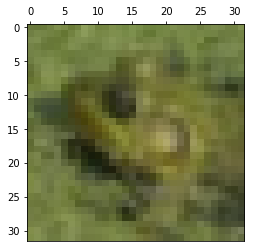

I PREDICT:  Frog
REAL VALUE:  Frog



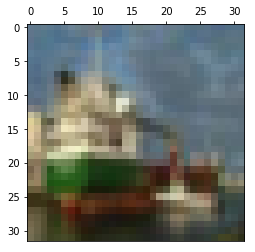

I PREDICT:  Ship
REAL VALUE:  Ship



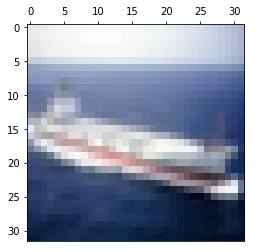

I PREDICT:  Ship
REAL VALUE:  Ship



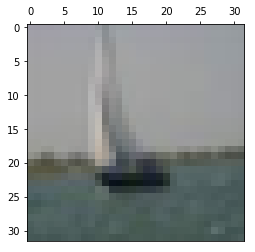

I PREDICT:  Ship
REAL VALUE:  Ship



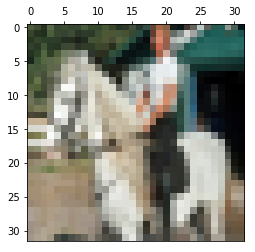

I PREDICT:  Horse
REAL VALUE:  Horse



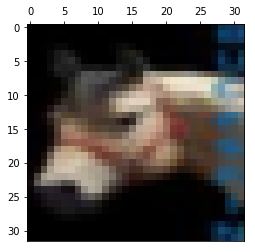

I PREDICT:  Horse
REAL VALUE:  Horse



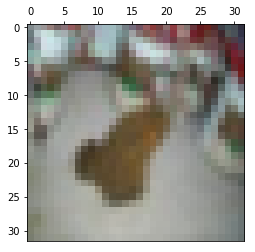

I PREDICT:  Frog
REAL VALUE:  Frog



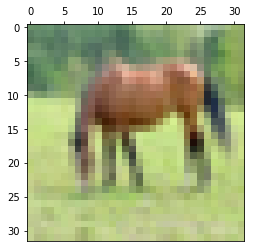

I PREDICT:  Horse
REAL VALUE:  Horse



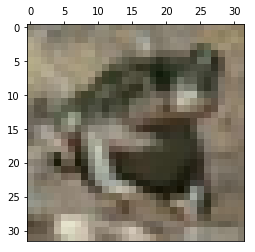

I PREDICT:  Frog
REAL VALUE:  Frog



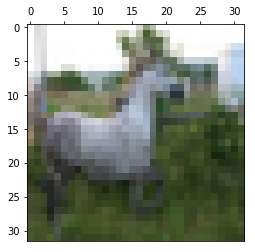

I PREDICT:  Horse
REAL VALUE:  Horse



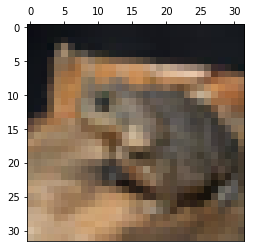

I PREDICT:  Frog
REAL VALUE:  Frog



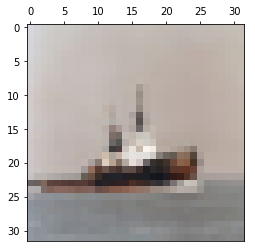

I PREDICT:  Ship
REAL VALUE:  Ship



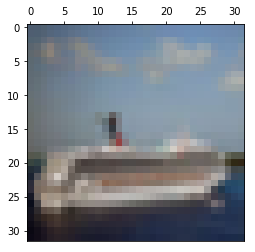

I PREDICT:  Ship
REAL VALUE:  Ship



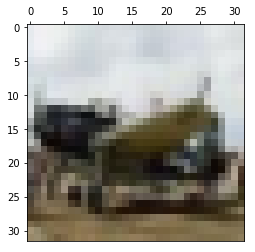

I PREDICT:  Airplane
REAL VALUE:  Airplane



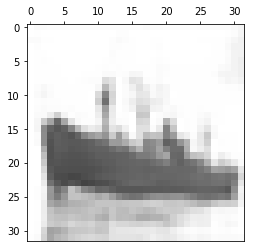

I PREDICT:  Ship
REAL VALUE:  Ship



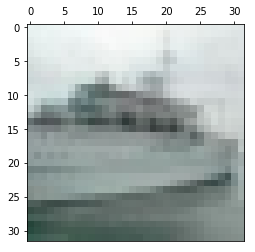

I PREDICT:  Ship
REAL VALUE:  Ship



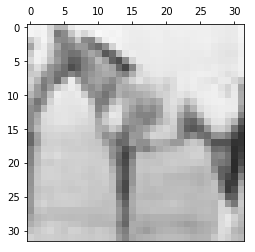

I PREDICT:  Horse
REAL VALUE:  Horse



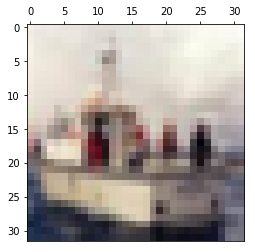

I PREDICT:  Ship
REAL VALUE:  Ship



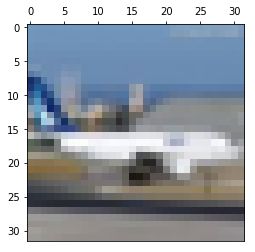

I PREDICT:  Airplane
REAL VALUE:  Airplane



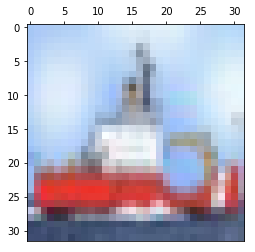

I PREDICT:  Ship
REAL VALUE:  Ship



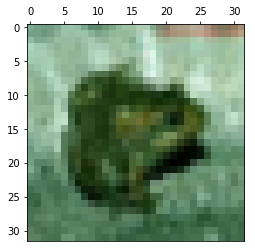

I PREDICT:  Frog
REAL VALUE:  Frog



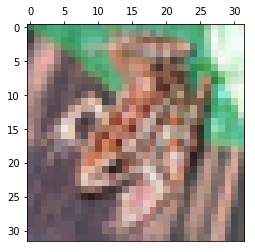

I PREDICT:  Frog
REAL VALUE:  Frog



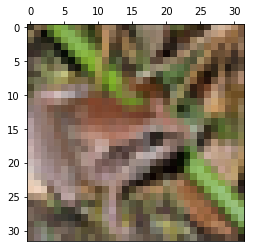

I PREDICT:  Frog
REAL VALUE:  Frog



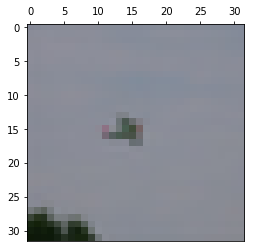

I PREDICT:  Airplane
REAL VALUE:  Airplane



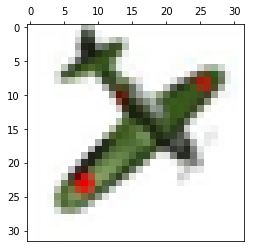

I PREDICT:  Airplane
REAL VALUE:  Airplane



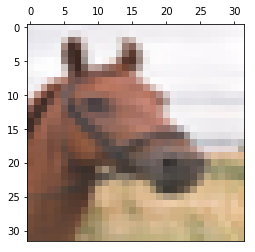

I PREDICT:  Horse
REAL VALUE:  Horse



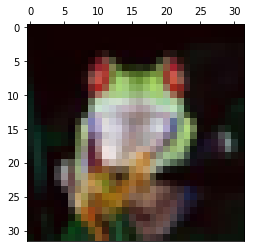

I PREDICT:  Frog
REAL VALUE:  Frog



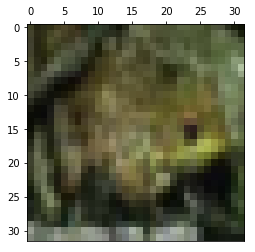

I PREDICT:  Frog
REAL VALUE:  Frog



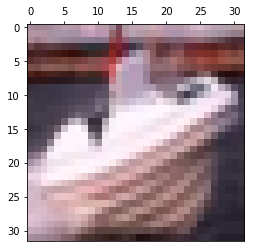

I PREDICT:  Ship
REAL VALUE:  Ship



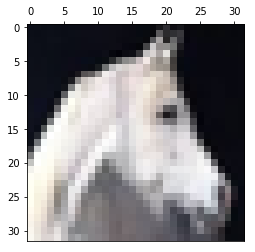

I PREDICT:  Horse
REAL VALUE:  Horse



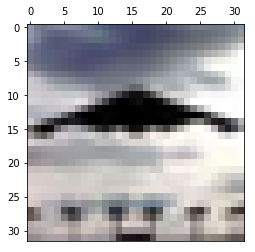

I PREDICT:  Airplane
REAL VALUE:  Airplane



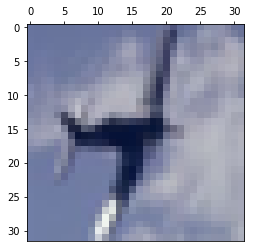

I PREDICT:  Airplane
REAL VALUE:  Airplane



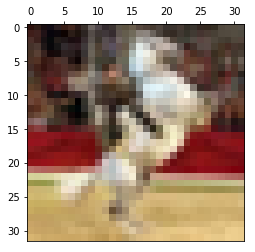

I PREDICT:  Horse
REAL VALUE:  Horse



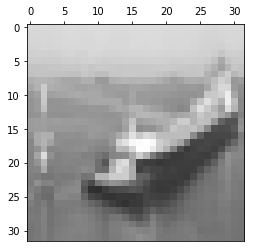

I PREDICT:  Ship
REAL VALUE:  Ship



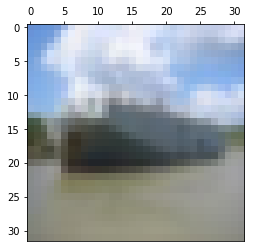

I PREDICT:  Ship
REAL VALUE:  Ship



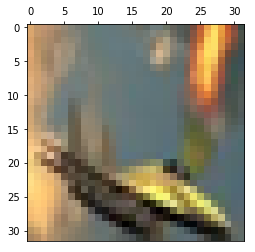

I PREDICT:  Airplane
REAL VALUE:  Airplane



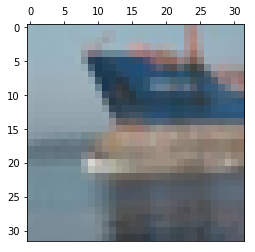

I PREDICT:  Ship
REAL VALUE:  Ship



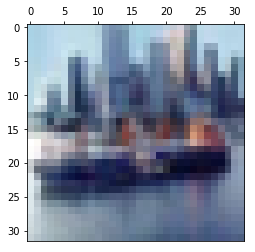

I PREDICT:  Ship
REAL VALUE:  Ship



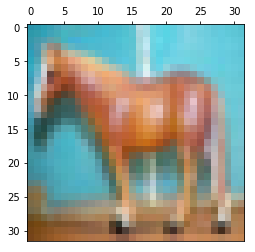

I PREDICT:  Horse
REAL VALUE:  Horse



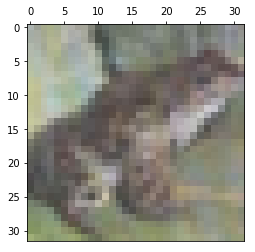

I PREDICT:  Frog
REAL VALUE:  Frog



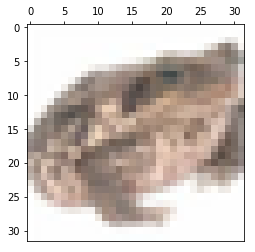

I PREDICT:  Frog
REAL VALUE:  Frog



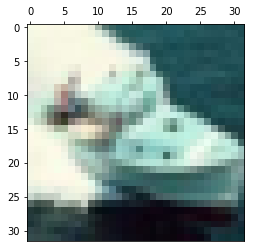

I PREDICT:  Ship
REAL VALUE:  Ship



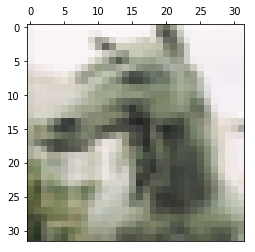

I PREDICT:  Horse
REAL VALUE:  Horse



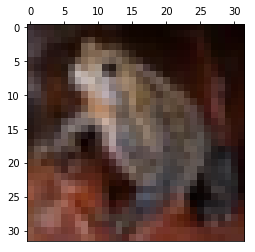

I PREDICT:  Frog
REAL VALUE:  Frog



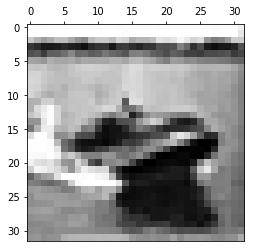

I PREDICT:  Ship
REAL VALUE:  Ship



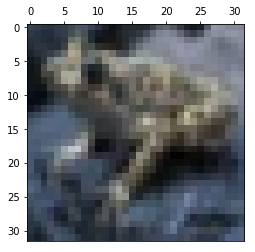

I PREDICT:  Frog
REAL VALUE:  Frog



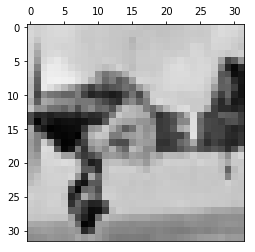

I PREDICT:  Airplane
REAL VALUE:  Airplane



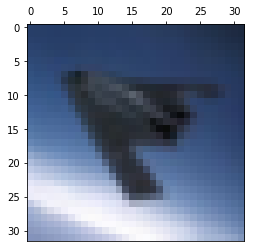

I PREDICT:  Airplane
REAL VALUE:  Airplane



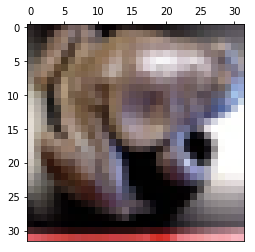

I PREDICT:  Frog
REAL VALUE:  Frog



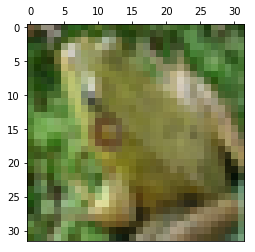

I PREDICT:  Frog
REAL VALUE:  Frog



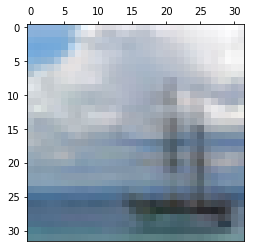

I PREDICT:  Ship
REAL VALUE:  Ship



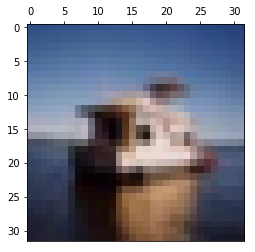

I PREDICT:  Ship
REAL VALUE:  Ship



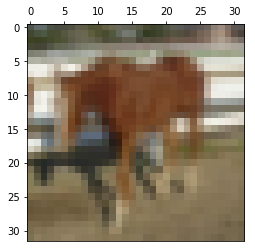

I PREDICT:  Horse
REAL VALUE:  Horse



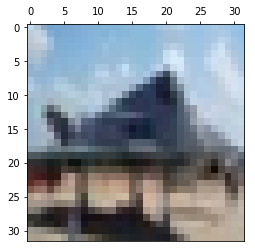

I PREDICT:  Airplane
REAL VALUE:  Airplane



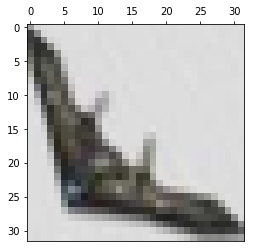

I PREDICT:  Airplane
REAL VALUE:  Airplane



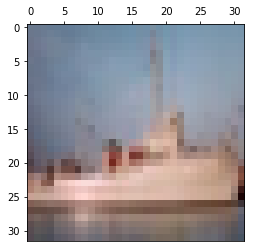

I PREDICT:  Ship
REAL VALUE:  Ship



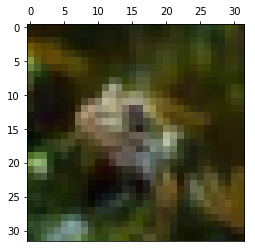

I PREDICT:  Frog
REAL VALUE:  Frog



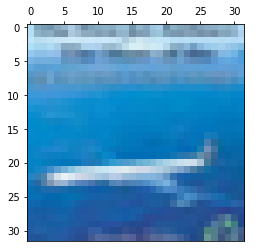

I PREDICT:  Airplane
REAL VALUE:  Airplane



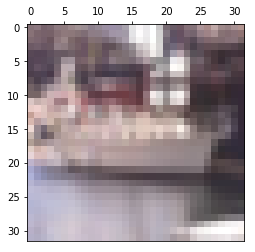

I PREDICT:  Ship
REAL VALUE:  Ship



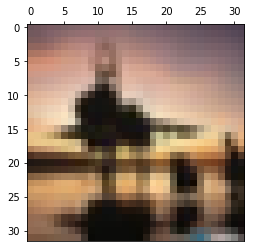

I PREDICT:  Airplane
REAL VALUE:  Airplane



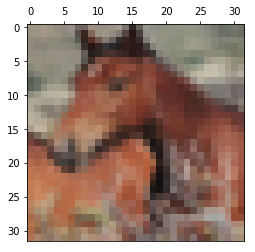

I PREDICT:  Horse
REAL VALUE:  Horse



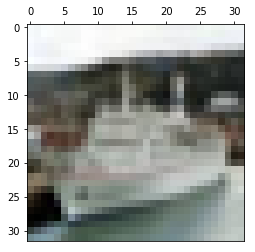

I PREDICT:  Ship
REAL VALUE:  Ship



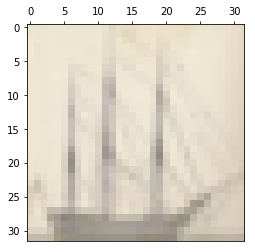

I PREDICT:  Ship
REAL VALUE:  Ship



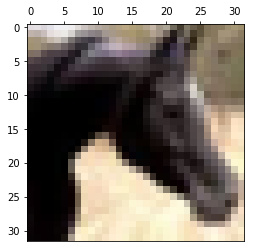

I PREDICT:  Horse
REAL VALUE:  Horse



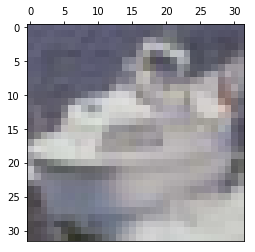

I PREDICT:  Ship
REAL VALUE:  Ship



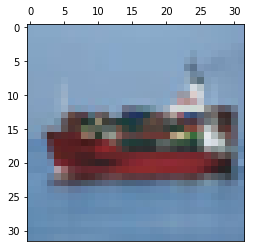

I PREDICT:  Ship
REAL VALUE:  Ship



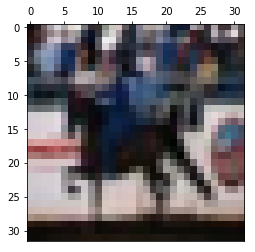

I PREDICT:  Horse
REAL VALUE:  Horse



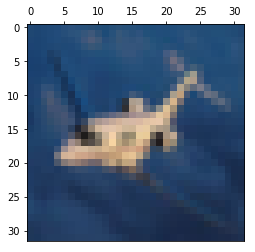

I PREDICT:  Airplane
REAL VALUE:  Airplane



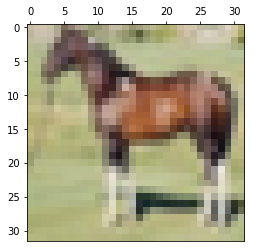

I PREDICT:  Horse
REAL VALUE:  Horse



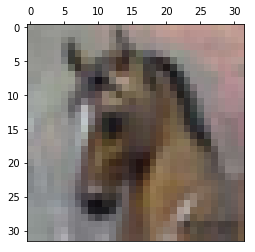

I PREDICT:  Horse
REAL VALUE:  Horse



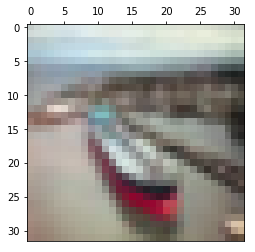

I PREDICT:  Ship
REAL VALUE:  Ship



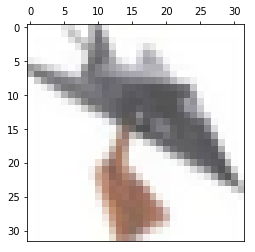

I PREDICT:  Airplane
REAL VALUE:  Airplane



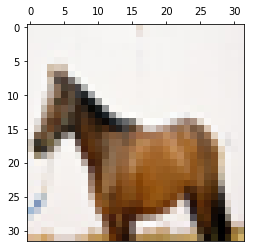

I PREDICT:  Horse
REAL VALUE:  Horse



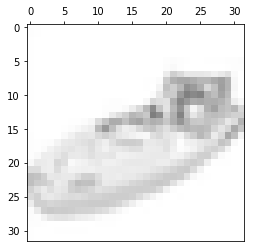

I PREDICT:  Ship
REAL VALUE:  Ship



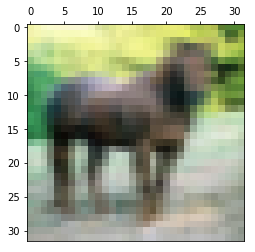

I PREDICT:  Horse
REAL VALUE:  Horse



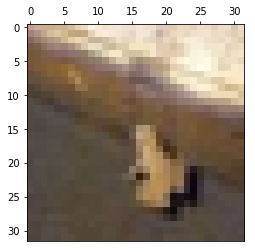

I PREDICT:  Frog
REAL VALUE:  Frog



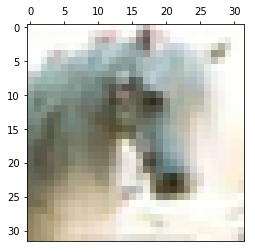

I PREDICT:  Horse
REAL VALUE:  Horse



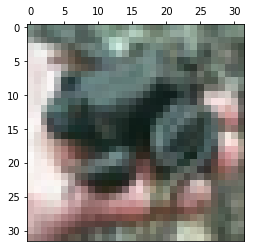

I PREDICT:  Frog
REAL VALUE:  Frog



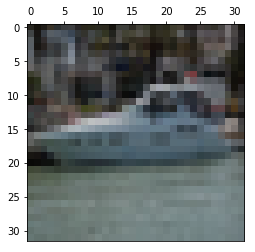

I PREDICT:  Ship
REAL VALUE:  Ship



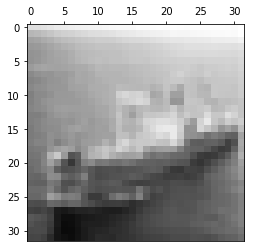

I PREDICT:  Ship
REAL VALUE:  Ship



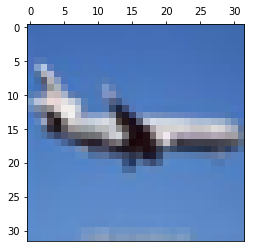

I PREDICT:  Airplane
REAL VALUE:  Airplane



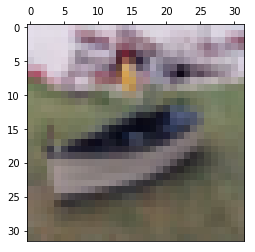

I PREDICT:  Ship
REAL VALUE:  Ship



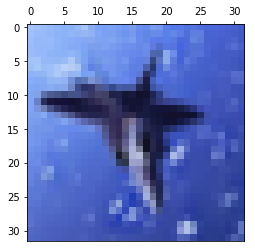

I PREDICT:  Airplane
REAL VALUE:  Airplane



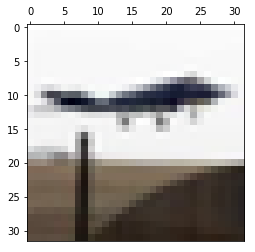

I PREDICT:  Airplane
REAL VALUE:  Airplane



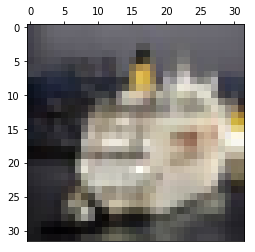

I PREDICT:  Ship
REAL VALUE:  Ship



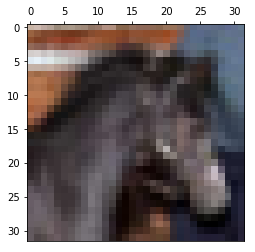

I PREDICT:  Horse
REAL VALUE:  Horse



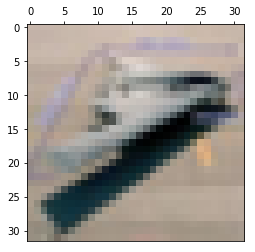

I PREDICT:  Airplane
REAL VALUE:  Airplane



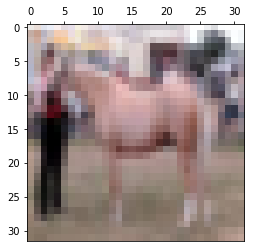

I PREDICT:  Horse
REAL VALUE:  Horse



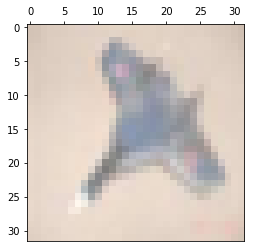

I PREDICT:  Airplane
REAL VALUE:  Airplane



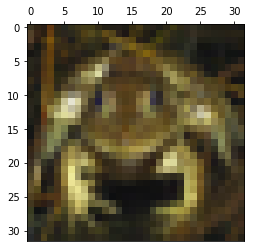

I PREDICT:  Frog
REAL VALUE:  Frog



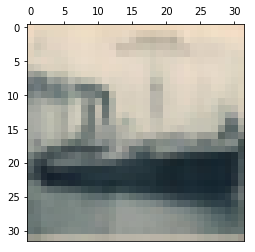

I PREDICT:  Ship
REAL VALUE:  Ship



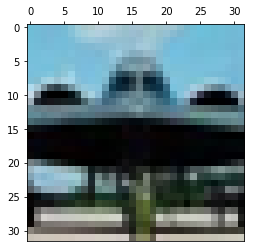

I PREDICT:  Airplane
REAL VALUE:  Airplane



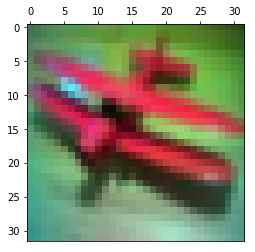

I PREDICT:  Airplane
REAL VALUE:  Airplane



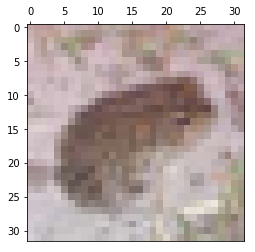

I PREDICT:  Frog
REAL VALUE:  Frog



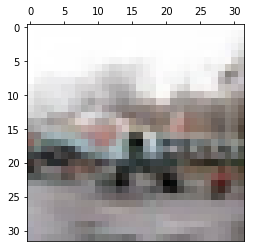

I PREDICT:  Airplane
REAL VALUE:  Airplane



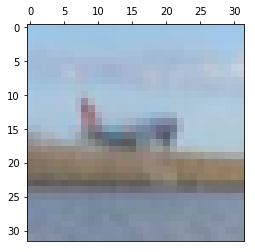

I PREDICT:  Airplane
REAL VALUE:  Airplane



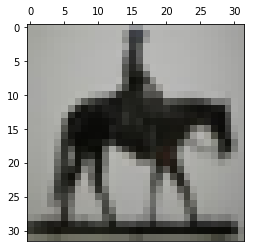

I PREDICT:  Horse
REAL VALUE:  Horse



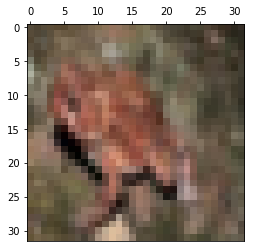

I PREDICT:  Frog
REAL VALUE:  Frog



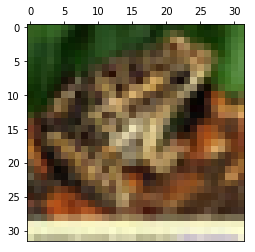

I PREDICT:  Frog
REAL VALUE:  Frog



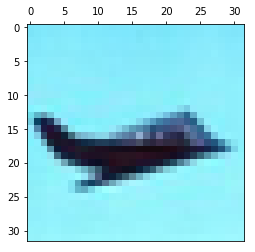

I PREDICT:  Airplane
REAL VALUE:  Airplane



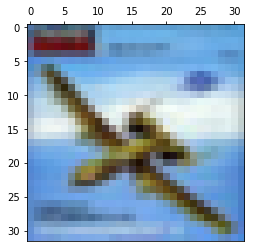

I PREDICT:  Airplane
REAL VALUE:  Airplane



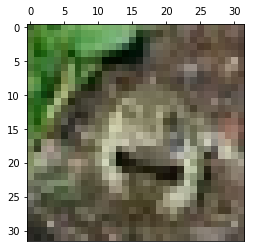

I PREDICT:  Frog
REAL VALUE:  Frog



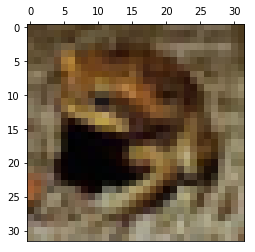

I PREDICT:  Frog
REAL VALUE:  Frog



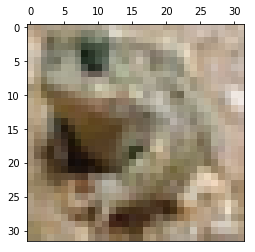

I PREDICT:  Frog
REAL VALUE:  Frog



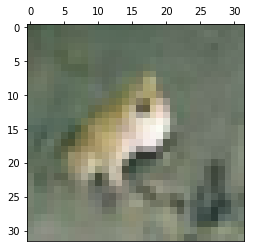

I PREDICT:  Frog
REAL VALUE:  Frog



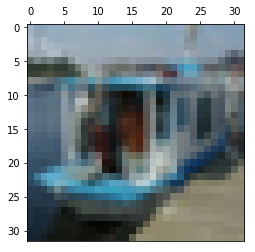

I PREDICT:  Ship
REAL VALUE:  Ship



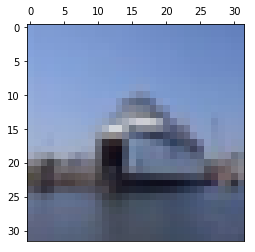

I PREDICT:  Ship
REAL VALUE:  Ship



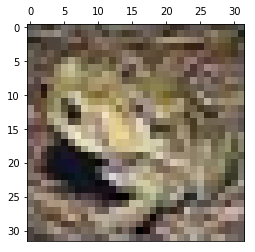

I PREDICT:  Frog
REAL VALUE:  Frog



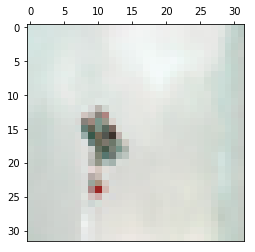

I PREDICT:  Airplane
REAL VALUE:  Airplane



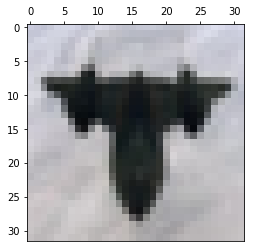

I PREDICT:  Airplane
REAL VALUE:  Airplane



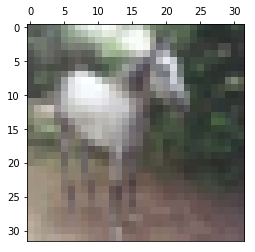

I PREDICT:  Horse
REAL VALUE:  Horse



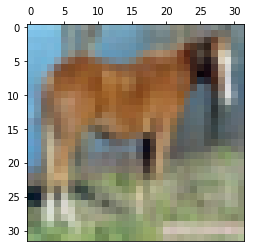

I PREDICT:  Horse
REAL VALUE:  Horse



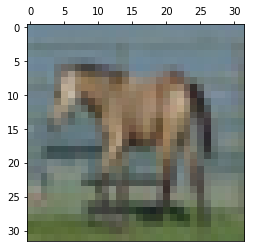

I PREDICT:  Horse
REAL VALUE:  Horse



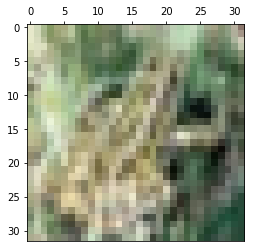

I PREDICT:  Frog
REAL VALUE:  Frog



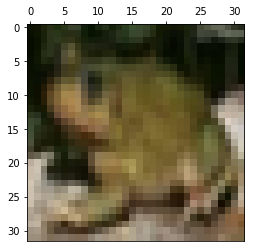

I PREDICT:  Frog
REAL VALUE:  Frog



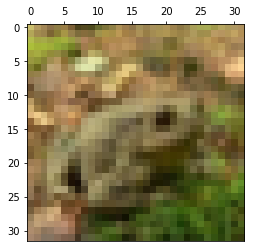

I PREDICT:  Frog
REAL VALUE:  Frog



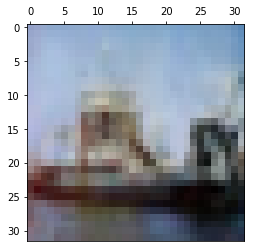

I PREDICT:  Ship
REAL VALUE:  Ship



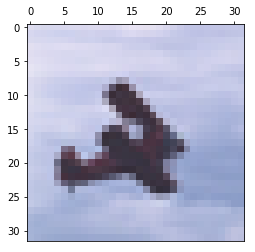

I PREDICT:  Airplane
REAL VALUE:  Airplane



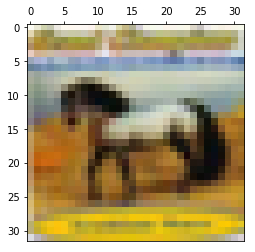

I PREDICT:  Horse
REAL VALUE:  Horse



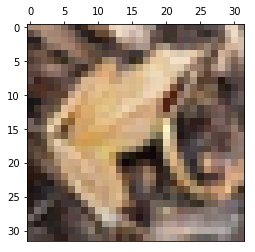

I PREDICT:  Frog
REAL VALUE:  Frog



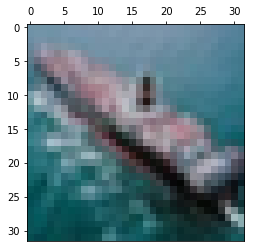

I PREDICT:  Ship
REAL VALUE:  Ship



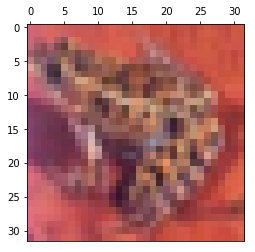

I PREDICT:  Frog
REAL VALUE:  Frog



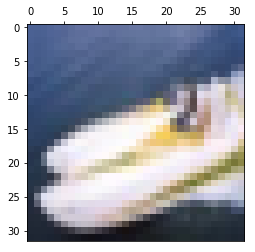

I PREDICT:  Ship
REAL VALUE:  Ship



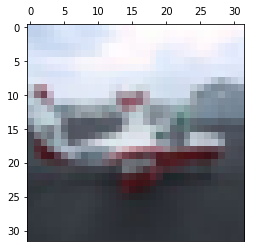

I PREDICT:  Airplane
REAL VALUE:  Airplane



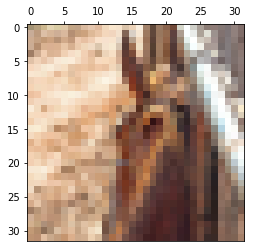

I PREDICT:  Horse
REAL VALUE:  Horse



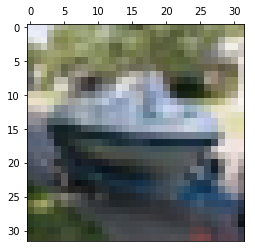

I PREDICT:  Ship
REAL VALUE:  Ship



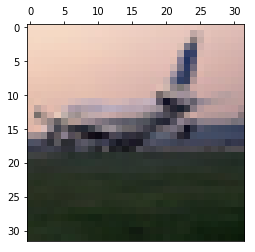

I PREDICT:  Airplane
REAL VALUE:  Airplane



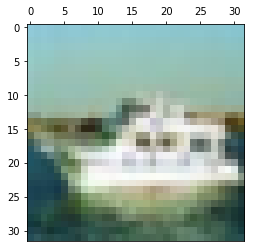

I PREDICT:  Ship
REAL VALUE:  Ship



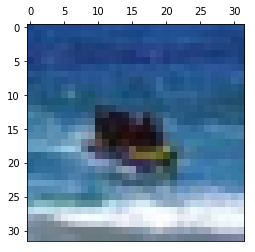

I PREDICT:  Ship
REAL VALUE:  Ship



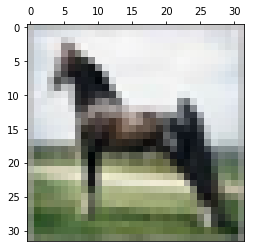

I PREDICT:  Horse
REAL VALUE:  Horse



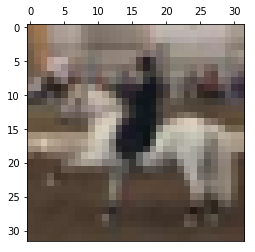

I PREDICT:  Horse
REAL VALUE:  Horse



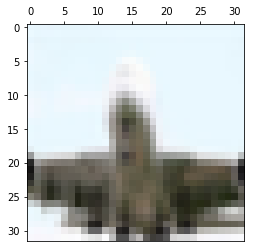

I PREDICT:  Airplane
REAL VALUE:  Airplane



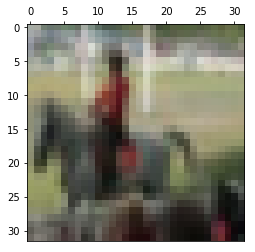

I PREDICT:  Horse
REAL VALUE:  Horse



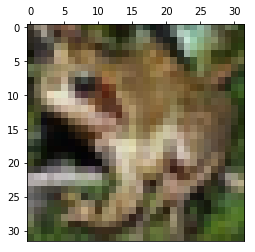

I PREDICT:  Frog
REAL VALUE:  Frog



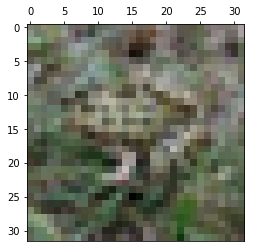

I PREDICT:  Frog
REAL VALUE:  Frog



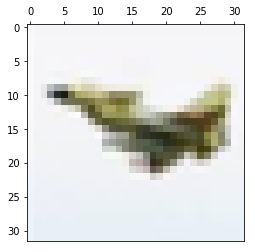

I PREDICT:  Airplane
REAL VALUE:  Airplane



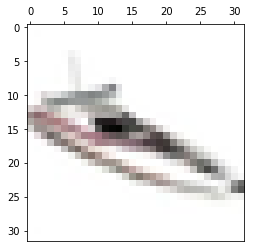

I PREDICT:  Ship
REAL VALUE:  Ship



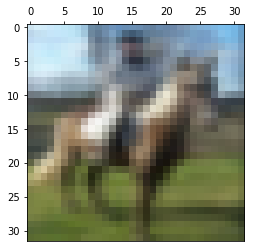

I PREDICT:  Horse
REAL VALUE:  Horse



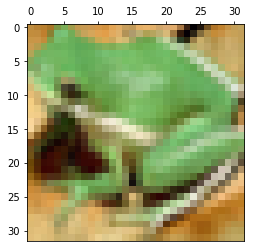

I PREDICT:  Frog
REAL VALUE:  Frog



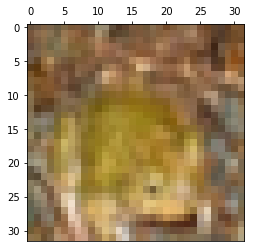

I PREDICT:  Frog
REAL VALUE:  Frog



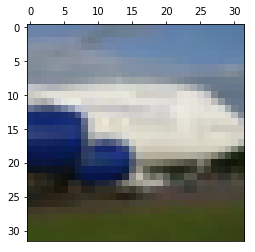

I PREDICT:  Airplane
REAL VALUE:  Airplane



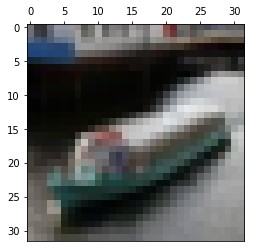

I PREDICT:  Ship
REAL VALUE:  Ship



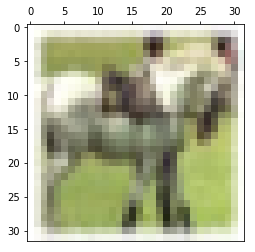

I PREDICT:  Horse
REAL VALUE:  Horse



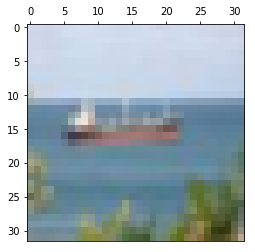

I PREDICT:  Ship
REAL VALUE:  Ship



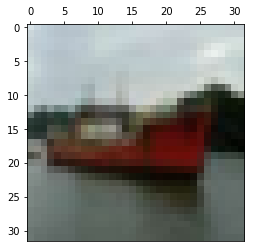

I PREDICT:  Ship
REAL VALUE:  Ship



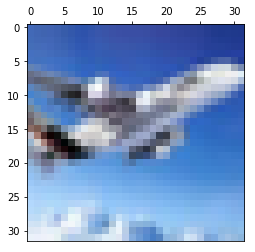

I PREDICT:  Airplane
REAL VALUE:  Airplane



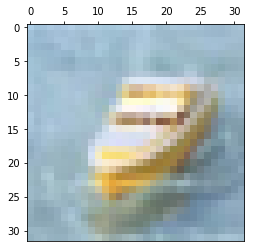

I PREDICT:  Ship
REAL VALUE:  Ship



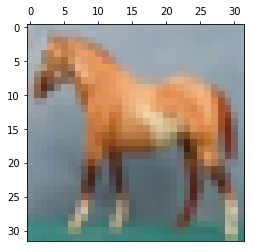

I PREDICT:  Horse
REAL VALUE:  Horse



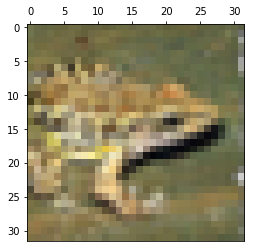

I PREDICT:  Frog
REAL VALUE:  Frog



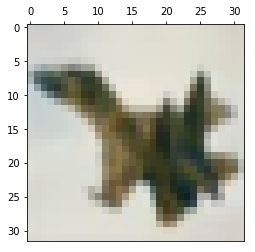

I PREDICT:  Airplane
REAL VALUE:  Airplane



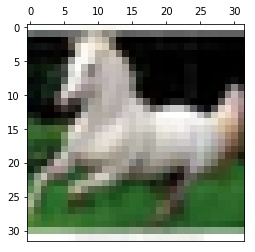

I PREDICT:  Horse
REAL VALUE:  Horse



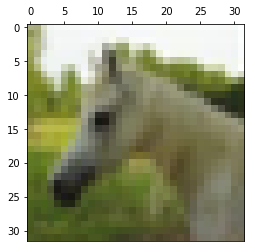

I PREDICT:  Horse
REAL VALUE:  Horse



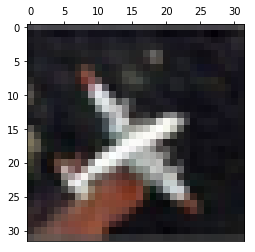

I PREDICT:  Airplane
REAL VALUE:  Airplane



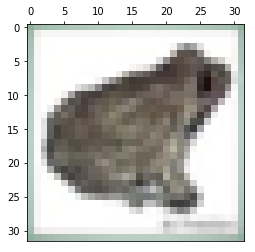

I PREDICT:  Frog
REAL VALUE:  Frog



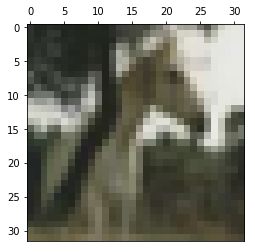

I PREDICT:  Horse
REAL VALUE:  Horse



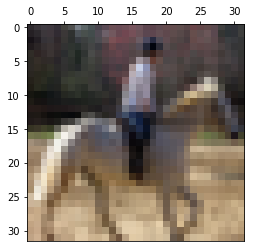

I PREDICT:  Horse
REAL VALUE:  Horse



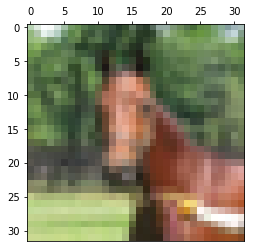

I PREDICT:  Horse
REAL VALUE:  Horse



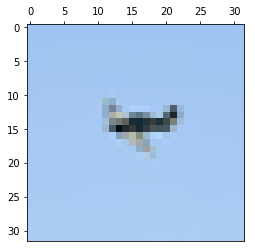

I PREDICT:  Airplane
REAL VALUE:  Airplane



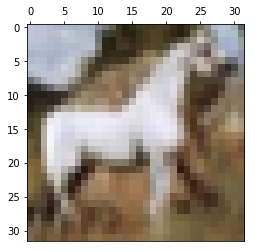

I PREDICT:  Horse
REAL VALUE:  Horse



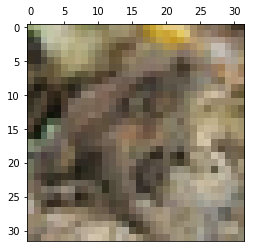

I PREDICT:  Frog
REAL VALUE:  Frog



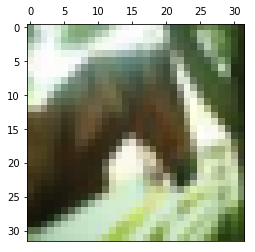

I PREDICT:  Horse
REAL VALUE:  Horse



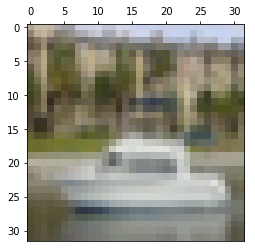

I PREDICT:  Ship
REAL VALUE:  Ship



In [20]:
for i in range(0, 200):
    if test_y[i] == svm_predictions[i]:
        display(test_x[i])
        print("I PREDICT: ", get_class(svm_predictions[i]))
        print("REAL VALUE: ", get_class(test_y[i]))
        print("")

# Cut to layer block4_pool

In [52]:
model = Model(inputs = pre_trained.input, outputs = pre_trained.get_layer('block4_pool').output)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [53]:
flatten_train = get_features(model, train_x)
flatten_test = get_features(model, test_x)

In [54]:
print(flatten_train.shape)
print(flatten_test.shape)

(20000, 2048)
(4000, 2048)


In [55]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(flatten_train, train_y)

In [56]:
accuracy = svm_model_linear.score(flatten_test, test_y) 
model_accuracy.append(accuracy)

In [57]:
svm_predictions = svm_model_linear.predict(flatten_test) 

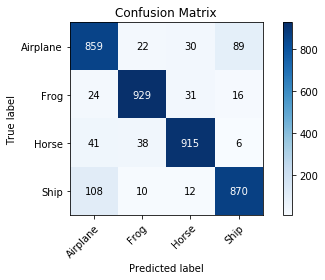

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.93      0.93      0.93      1000
           2       0.93      0.92      0.92      1000
           3       0.89      0.87      0.88      1000

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000

0.89325


In [58]:
plotConfusionMatrix(test_y, svm_predictions, ['Airplane', 'Frog', 'Horse', 'Ship'], False, "Confusion Matrix")
report = classification_report(test_y, svm_predictions)
print(report)
print(accuracy)

# Cut to layer block5_pool

In [59]:
model = Model(inputs = pre_trained.input, outputs = pre_trained.get_layer('block5_pool').output)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [60]:
flatten_train = get_features(model, train_x)
flatten_test = get_features(model, test_x)

In [61]:
print(flatten_train.shape)
print(flatten_test.shape)

(20000, 512)
(4000, 512)


In [62]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(flatten_train, train_y)

In [63]:
accuracy = svm_model_linear.score(flatten_test, test_y) 
model_accuracy.append(accuracy)

In [64]:
svm_predictions = svm_model_linear.predict(flatten_test) 

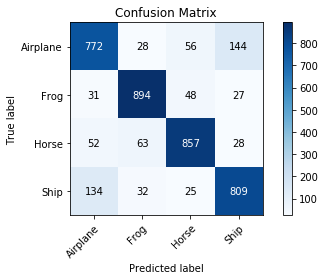

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1000
           1       0.88      0.89      0.89      1000
           2       0.87      0.86      0.86      1000
           3       0.80      0.81      0.81      1000

   micro avg       0.83      0.83      0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000

0.833


In [65]:
plotConfusionMatrix(test_y, svm_predictions, ['Airplane', 'Frog', 'Horse', 'Ship'], False, "Confusion Matrix")
report = classification_report(test_y, svm_predictions)
print(report)
print(accuracy)

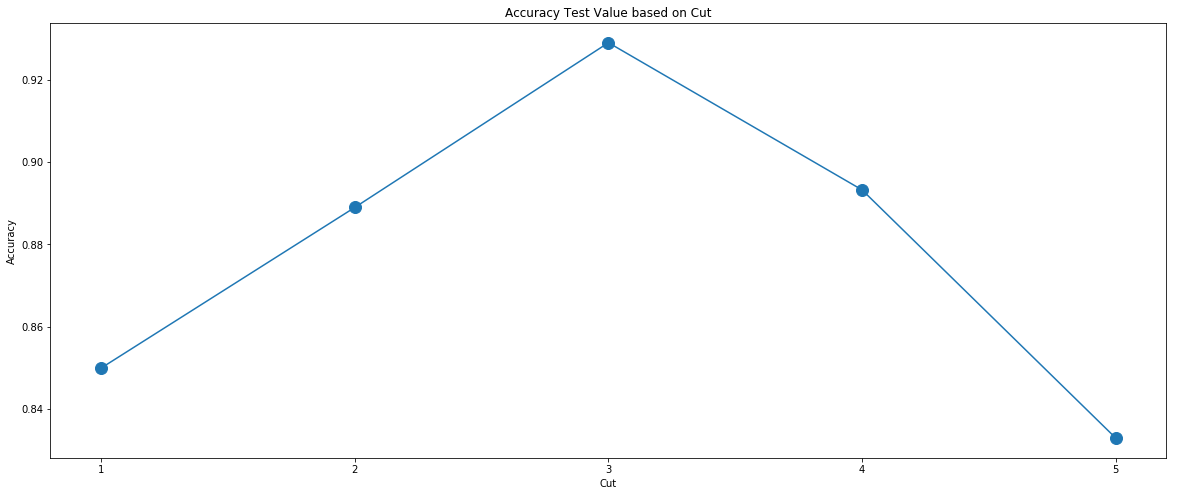

In [83]:
area = np.pi*30

# Plot
plt.figure(figsize=(20,8))
# plt.scatter(['1', '2', '3', '4', '5'], model_accuracy, s = area, alpha=1.0)
plt.plot(['1', '2', '3', '4', '5'], model_accuracy, 'o-', markersize=12)
plt.title('Accuracy Test Value based on Cut')
plt.xlabel('Cut')
plt.ylabel('Accuracy')
plt.show()